# Лабораторная работа 8
Вихляев Егор, ММТ-21

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

import warnings 
warnings.filterwarnings('ignore')

# Загрузим данные

In [3]:
df = pd.read_csv('Tweets.csv')

In [4]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Переменные textID и selected_text нам явно не понадобятся, так что уберем их из датафрейма

In [5]:
df = df.drop(['textID', 'selected_text'], axis=1)

In [6]:
df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [7]:
df.shape

(27481, 2)

In [8]:
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,All this flirting going on - The ATG smiles...,neutral
freq,1,11118


In [9]:
df.isnull().sum()

text         1
sentiment    0
dtype: int64

Датасет имеет одно нулевое значение. Выкинем его

In [10]:
df.dropna(inplace=True)

Проверим на дубликаты

In [11]:
df.duplicated().sum()

np.int64(0)

Дубликатов не найдено

In [12]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head()

,text,stopwords
0,"I`d have responded, if I were going",3
1,Sooo SAD I will miss you here in San Diego!!!,4
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",7


In [14]:
df.drop(['stopwords'], axis=1)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


Визуализируем слова

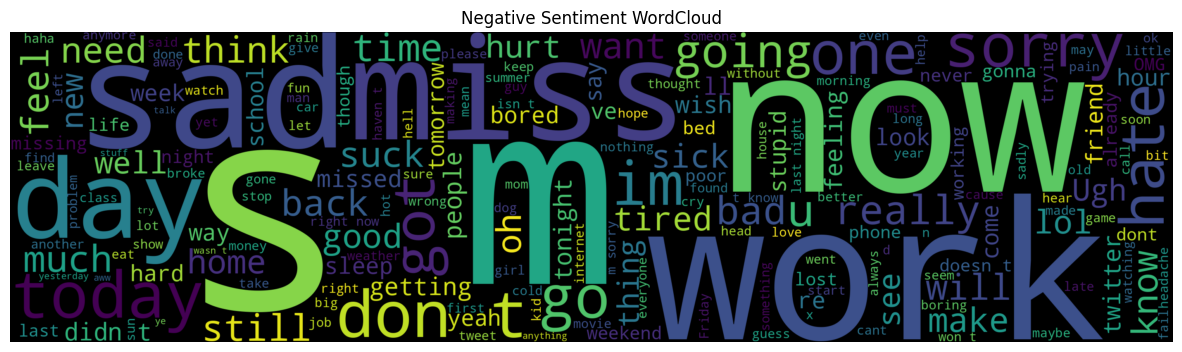

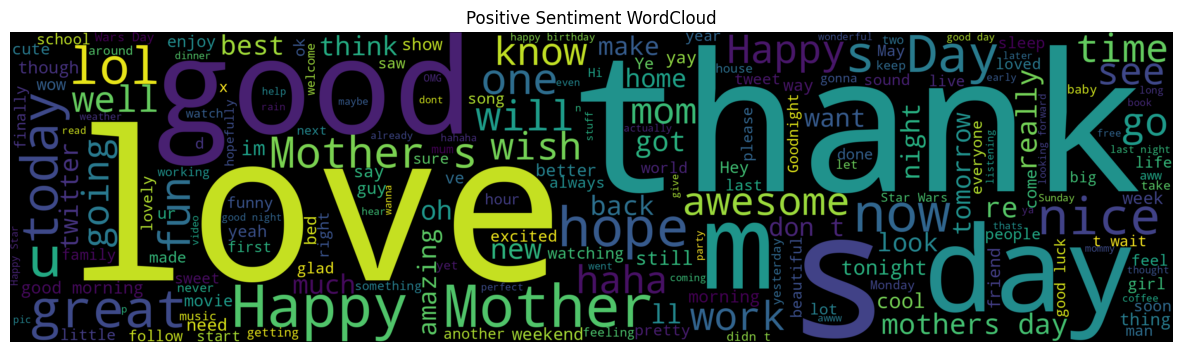

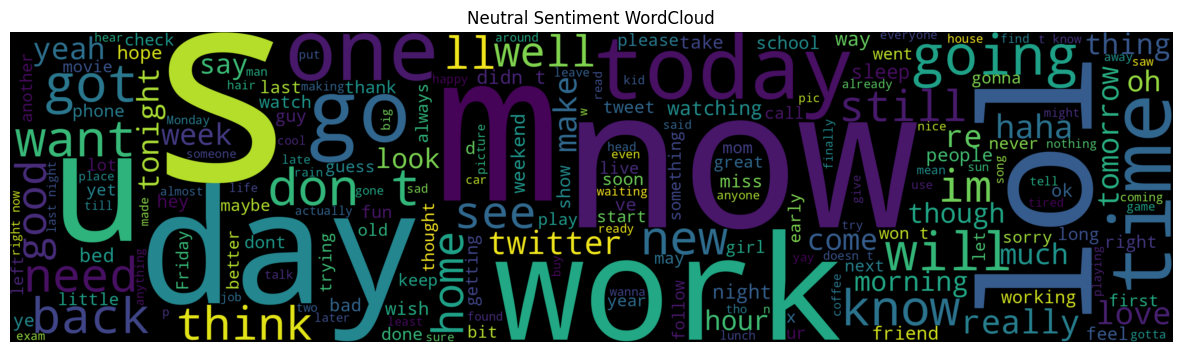

In [15]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


Конвертируем текст в нижний регистр

In [16]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

Удалим знаки препинания

In [17]:
df['text'].str.replace('[^\w\s]','')

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4        sons of ****, why couldn`t they put them on th...
                               ...                        
27476    wish we could come see u on denver husband los...
27477    i`ve wondered about rake to. the client has ma...
27478    yay good for both of you. enjoy the break - yo...
27479                            but it was worth it ****.
27480    all this flirting going on - the atg smiles. y...
Name: text, Length: 27480, dtype: object

Удалим стоп-слова

In [18]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

In [19]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:30]
freq

i`m       2173
day       1481
get       1415
good      1325
like      1303
it`s      1174
go        1162
-         1147
got       1069
going     1062
love      1060
happy      914
work       878
don`t      850
u          848
really     841
one        838
im         824
****       796
back       781
see        765
know       757
can`t      746
time       739
new        725
lol        697
want       695
&          675
still      661
think      656
Name: count, dtype: int64

Удалим местоимения, артикли, ненужные символы

In [20]:
freq =["I'm", "-", "****", "&"]
df['text']= df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

In [21]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq

hoooray!            1
drawls..            1
preseason           1
teniece             1
microsoft.          1
360,                1
modded              1
hahahahahaha!!!!    1
nooooo.....         1
bicycle             1
Name: count, dtype: int64

Удалим различного рода окончания

In [22]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0                               i`d responded, go
1                      sooo sad miss san diego!!!
2                                boss bulli me...
3                            interview! leav alon
4    son ****, couldn`t put releas alreadi bought
Name: text, dtype: object

In [23]:
df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [24]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

In [25]:
df

,text,sentiment,stopwords,label
0,"i`d responded, going",neutral,3,1
1,sooo sad miss san diego!!!,negative,4,0
2,boss bullying me...,negative,2,0
3,interview! leave alone,negative,2,0
4,"sons ****, couldn`t put releases already bought",negative,7,0
...,...,...,...,...
27476,wish could come see u denver husband lost job ...,negative,5,0
27477,i`ve wondered rake to. client made clear .net ...,negative,5,0
27478,yay good you. enjoy break probably need hectic...,positive,8,2
27479,worth ****.,positive,3,2


In [26]:
X = df['text']
y = df['label']

# BERT

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки:', X_train.shape[0])
print('Размер валидационной выборки:', X_val.shape[0])

Размер тренировочной выборки: 21984
Размер валидационной выборки: 5496


In [28]:
X_train = [str(x) for x in X_train]

print(type(X_train))
print(X_train)

<class 'list'>
['oh, he`s hilarious. i`m commenting fact he`s much.', 'thanks trying hoping bud trillin, fest would honored guests hobnobbed.', 'show house rocked! saying goodbye soon', '4:30am west coast time..gettin ready catch flight back home..soooo excited go back two fav boyzzzz puppy n bf', 'computer slooowww morning. think it`s sign go home play yard.', 'lol! thought suppose guess..****, tried tho..lolol!', 'today lovely day! fun evening!', 'moodle intro training morning... ages since i`ve done that... 2 bookings', 'want new lappy', 'looks like nap wait. i`m still waiting poor guy', 'awww boys beards? liked manly man-ness [via ] #asylm', 'congratulation`s phil packer completing london marathon x shining example us x', 'thought u go #2 tummy supposed feel better worse', 'there`s loads highly qualified stuff loads still using snail mail.', 'u little prob ur twitter happen @ old pep resteraunt! mayb help u fix', 'true don`t put case i`ll break week. don`t worry ill find way make w

In [29]:
import transformers
import accelerate
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import warnings

In [30]:
# Загружаем токенайзер для BERT'a
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Токенизируем входящий текст
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

In [31]:
# Создадим класс данных PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key:torch.tensor(val[idx], dtype=torch.long)
                for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

In [32]:
# Создадим датасеты для тренировки, валидации и тестирования выборок
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
val_dataset = SentimentDataset(val_encodings, y_val.tolist())

In [33]:
# Загружаем BERT для классификации
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Определяем тренировочные аргументы
training_args = TrainingArguments(
    output_dir='../logs',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [35]:
# Инициализируем тренировку
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [36]:
# Тренируем модель
trainer.train()

  0%|          | 11/8244 [00:01<11:57, 11.48it/s]

{'loss': 1.2017, 'grad_norm': 8.93052864074707, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}


  0%|          | 21/8244 [00:01<11:25, 11.99it/s]

{'loss': 1.1482, 'grad_norm': 7.866737365722656, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}


  0%|          | 31/8244 [00:02<11:19, 12.09it/s]

{'loss': 1.156, 'grad_norm': 5.1797871589660645, 'learning_rate': 3e-06, 'epoch': 0.01}


  0%|          | 41/8244 [00:03<11:19, 12.08it/s]

{'loss': 1.1453, 'grad_norm': 6.104055404663086, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}


  1%|          | 51/8244 [00:04<11:18, 12.08it/s]

{'loss': 1.1023, 'grad_norm': 4.886684417724609, 'learning_rate': 5e-06, 'epoch': 0.02}


  1%|          | 61/8244 [00:05<11:16, 12.10it/s]

{'loss': 1.1097, 'grad_norm': 6.136224746704102, 'learning_rate': 6e-06, 'epoch': 0.02}


  1%|          | 71/8244 [00:06<11:15, 12.11it/s]

{'loss': 1.0889, 'grad_norm': 6.448667049407959, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.03}


  1%|          | 81/8244 [00:06<11:20, 12.00it/s]

{'loss': 1.1003, 'grad_norm': 6.0735602378845215, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.03}


  1%|          | 91/8244 [00:07<11:16, 12.04it/s]

{'loss': 1.0981, 'grad_norm': 11.109749794006348, 'learning_rate': 9e-06, 'epoch': 0.03}


  1%|          | 101/8244 [00:08<11:15, 12.05it/s]

{'loss': 1.0718, 'grad_norm': 7.70073938369751, 'learning_rate': 1e-05, 'epoch': 0.04}


  1%|▏         | 111/8244 [00:09<11:12, 12.09it/s]

{'loss': 1.0845, 'grad_norm': 6.849968910217285, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.04}


  1%|▏         | 121/8244 [00:10<11:12, 12.08it/s]

{'loss': 1.0915, 'grad_norm': 7.451718330383301, 'learning_rate': 1.2e-05, 'epoch': 0.04}


  2%|▏         | 131/8244 [00:10<11:11, 12.08it/s]

{'loss': 1.0213, 'grad_norm': 6.019858360290527, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.05}


  2%|▏         | 141/8244 [00:11<11:11, 12.06it/s]

{'loss': 1.0237, 'grad_norm': 5.772053241729736, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.05}


  2%|▏         | 151/8244 [00:12<11:11, 12.05it/s]

{'loss': 0.9951, 'grad_norm': 5.842155456542969, 'learning_rate': 1.5e-05, 'epoch': 0.05}


  2%|▏         | 161/8244 [00:13<11:10, 12.05it/s]

{'loss': 0.9577, 'grad_norm': 7.568805694580078, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.06}


  2%|▏         | 171/8244 [00:14<11:08, 12.08it/s]

{'loss': 0.9358, 'grad_norm': 7.023169040679932, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.06}


  2%|▏         | 181/8244 [00:15<11:08, 12.06it/s]

{'loss': 0.9965, 'grad_norm': 14.007840156555176, 'learning_rate': 1.8e-05, 'epoch': 0.07}


  2%|▏         | 191/8244 [00:15<11:07, 12.06it/s]

{'loss': 0.8953, 'grad_norm': 11.275186538696289, 'learning_rate': 1.9e-05, 'epoch': 0.07}


  2%|▏         | 201/8244 [00:16<11:05, 12.08it/s]

{'loss': 0.8017, 'grad_norm': 7.15066385269165, 'learning_rate': 2e-05, 'epoch': 0.07}


  3%|▎         | 211/8244 [00:17<11:06, 12.06it/s]

{'loss': 0.8028, 'grad_norm': 8.143646240234375, 'learning_rate': 2.1e-05, 'epoch': 0.08}


  3%|▎         | 221/8244 [00:18<11:05, 12.05it/s]

{'loss': 0.7488, 'grad_norm': 9.549087524414062, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.08}


  3%|▎         | 231/8244 [00:19<11:04, 12.06it/s]

{'loss': 0.692, 'grad_norm': 11.224907875061035, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.08}


  3%|▎         | 241/8244 [00:20<11:03, 12.06it/s]

{'loss': 0.664, 'grad_norm': 28.001012802124023, 'learning_rate': 2.4e-05, 'epoch': 0.09}


  3%|▎         | 251/8244 [00:20<11:02, 12.06it/s]

{'loss': 0.8704, 'grad_norm': 4.922328948974609, 'learning_rate': 2.5e-05, 'epoch': 0.09}


  3%|▎         | 261/8244 [00:21<11:00, 12.08it/s]

{'loss': 1.0316, 'grad_norm': 16.016386032104492, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.09}


  3%|▎         | 271/8244 [00:22<11:00, 12.07it/s]

{'loss': 0.6876, 'grad_norm': 7.214672565460205, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.1}


  3%|▎         | 281/8244 [00:23<11:00, 12.06it/s]

{'loss': 0.7269, 'grad_norm': 15.623802185058594, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.1}


  4%|▎         | 291/8244 [00:24<10:57, 12.10it/s]

{'loss': 0.7209, 'grad_norm': 11.932594299316406, 'learning_rate': 2.9e-05, 'epoch': 0.11}


  4%|▎         | 301/8244 [00:25<10:59, 12.05it/s]

{'loss': 0.7805, 'grad_norm': 17.252771377563477, 'learning_rate': 3e-05, 'epoch': 0.11}


  4%|▍         | 311/8244 [00:25<10:57, 12.07it/s]

{'loss': 0.9221, 'grad_norm': 14.095832824707031, 'learning_rate': 3.1e-05, 'epoch': 0.11}


  4%|▍         | 321/8244 [00:26<10:56, 12.06it/s]

{'loss': 0.7412, 'grad_norm': 6.853374004364014, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.12}


  4%|▍         | 331/8244 [00:27<10:56, 12.05it/s]

{'loss': 0.9213, 'grad_norm': 13.44234848022461, 'learning_rate': 3.3e-05, 'epoch': 0.12}


  4%|▍         | 341/8244 [00:28<10:54, 12.07it/s]

{'loss': 0.6073, 'grad_norm': 6.89845609664917, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.12}


  4%|▍         | 351/8244 [00:29<10:55, 12.04it/s]

{'loss': 0.5329, 'grad_norm': 9.373181343078613, 'learning_rate': 3.5e-05, 'epoch': 0.13}


  4%|▍         | 361/8244 [00:30<10:53, 12.07it/s]

{'loss': 0.7014, 'grad_norm': 4.42254114151001, 'learning_rate': 3.6e-05, 'epoch': 0.13}


  5%|▍         | 371/8244 [00:30<10:51, 12.09it/s]

{'loss': 0.9707, 'grad_norm': 6.801271915435791, 'learning_rate': 3.7e-05, 'epoch': 0.13}


  5%|▍         | 381/8244 [00:31<10:51, 12.07it/s]

{'loss': 0.9008, 'grad_norm': 8.02979850769043, 'learning_rate': 3.8e-05, 'epoch': 0.14}


  5%|▍         | 391/8244 [00:32<10:50, 12.06it/s]

{'loss': 0.7777, 'grad_norm': 13.02303409576416, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.14}


  5%|▍         | 401/8244 [00:33<10:50, 12.05it/s]

{'loss': 0.7017, 'grad_norm': 15.610979080200195, 'learning_rate': 4e-05, 'epoch': 0.15}


  5%|▍         | 411/8244 [00:34<10:51, 12.01it/s]

{'loss': 0.7646, 'grad_norm': 7.224359512329102, 'learning_rate': 4.1e-05, 'epoch': 0.15}


  5%|▌         | 421/8244 [00:34<10:50, 12.03it/s]

{'loss': 0.645, 'grad_norm': 9.247915267944336, 'learning_rate': 4.2e-05, 'epoch': 0.15}


  5%|▌         | 431/8244 [00:35<10:48, 12.05it/s]

{'loss': 0.7925, 'grad_norm': 9.272383689880371, 'learning_rate': 4.3e-05, 'epoch': 0.16}


  5%|▌         | 441/8244 [00:36<10:46, 12.06it/s]

{'loss': 0.6191, 'grad_norm': 9.80356216430664, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.16}


  5%|▌         | 451/8244 [00:37<10:45, 12.08it/s]

{'loss': 0.7515, 'grad_norm': 7.222205638885498, 'learning_rate': 4.5e-05, 'epoch': 0.16}


  6%|▌         | 461/8244 [00:38<10:49, 11.98it/s]

{'loss': 0.6247, 'grad_norm': 11.368013381958008, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.17}


  6%|▌         | 471/8244 [00:39<10:45, 12.05it/s]

{'loss': 0.6557, 'grad_norm': 3.4264016151428223, 'learning_rate': 4.7e-05, 'epoch': 0.17}


  6%|▌         | 481/8244 [00:39<10:45, 12.02it/s]

{'loss': 0.7292, 'grad_norm': 17.343782424926758, 'learning_rate': 4.8e-05, 'epoch': 0.17}


  6%|▌         | 491/8244 [00:40<10:50, 11.92it/s]

{'loss': 0.7404, 'grad_norm': 39.27370071411133, 'learning_rate': 4.9e-05, 'epoch': 0.18}


  6%|▌         | 500/8244 [00:41<10:47, 11.95it/s]

{'loss': 0.7265, 'grad_norm': 15.8433837890625, 'learning_rate': 5e-05, 'epoch': 0.18}


  6%|▌         | 511/8244 [00:44<18:17,  7.04it/s]

{'loss': 0.6271, 'grad_norm': 23.487876892089844, 'learning_rate': 4.9935433884297525e-05, 'epoch': 0.19}


  6%|▋         | 521/8244 [00:45<12:03, 10.67it/s]

{'loss': 0.8216, 'grad_norm': 26.521364212036133, 'learning_rate': 4.987086776859504e-05, 'epoch': 0.19}


  6%|▋         | 531/8244 [00:46<11:00, 11.67it/s]

{'loss': 0.666, 'grad_norm': 9.454087257385254, 'learning_rate': 4.980630165289256e-05, 'epoch': 0.19}


  7%|▋         | 541/8244 [00:47<10:48, 11.88it/s]

{'loss': 0.8527, 'grad_norm': 11.1045560836792, 'learning_rate': 4.9741735537190085e-05, 'epoch': 0.2}


  7%|▋         | 551/8244 [00:48<10:50, 11.83it/s]

{'loss': 0.548, 'grad_norm': 7.789272308349609, 'learning_rate': 4.967716942148761e-05, 'epoch': 0.2}


  7%|▋         | 561/8244 [00:48<10:45, 11.91it/s]

{'loss': 0.8455, 'grad_norm': 11.47037124633789, 'learning_rate': 4.961260330578513e-05, 'epoch': 0.2}


  7%|▋         | 571/8244 [00:49<10:47, 11.86it/s]

{'loss': 0.5923, 'grad_norm': 5.301910877227783, 'learning_rate': 4.9548037190082645e-05, 'epoch': 0.21}


  7%|▋         | 581/8244 [00:50<10:45, 11.87it/s]

{'loss': 0.7005, 'grad_norm': 6.475180625915527, 'learning_rate': 4.948347107438017e-05, 'epoch': 0.21}


  7%|▋         | 591/8244 [00:51<10:44, 11.87it/s]

{'loss': 0.6489, 'grad_norm': 4.953802585601807, 'learning_rate': 4.941890495867768e-05, 'epoch': 0.21}


  7%|▋         | 601/8244 [00:52<10:43, 11.88it/s]

{'loss': 0.693, 'grad_norm': 16.983190536499023, 'learning_rate': 4.9354338842975205e-05, 'epoch': 0.22}


  7%|▋         | 611/8244 [00:53<10:41, 11.90it/s]

{'loss': 0.7976, 'grad_norm': 10.18471622467041, 'learning_rate': 4.9289772727272735e-05, 'epoch': 0.22}


  8%|▊         | 621/8244 [00:54<10:38, 11.94it/s]

{'loss': 0.5227, 'grad_norm': 7.602928161621094, 'learning_rate': 4.922520661157025e-05, 'epoch': 0.23}


  8%|▊         | 631/8244 [00:54<10:38, 11.92it/s]

{'loss': 0.9553, 'grad_norm': 9.765348434448242, 'learning_rate': 4.916064049586777e-05, 'epoch': 0.23}


  8%|▊         | 641/8244 [00:55<10:37, 11.93it/s]

{'loss': 0.6269, 'grad_norm': 12.83598518371582, 'learning_rate': 4.909607438016529e-05, 'epoch': 0.23}


  8%|▊         | 651/8244 [00:56<10:36, 11.92it/s]

{'loss': 0.7963, 'grad_norm': 13.247395515441895, 'learning_rate': 4.903150826446281e-05, 'epoch': 0.24}


  8%|▊         | 661/8244 [00:57<10:35, 11.93it/s]

{'loss': 0.7306, 'grad_norm': 17.379364013671875, 'learning_rate': 4.896694214876033e-05, 'epoch': 0.24}


  8%|▊         | 671/8244 [00:58<10:32, 11.97it/s]

{'loss': 0.7308, 'grad_norm': 8.135239601135254, 'learning_rate': 4.8902376033057855e-05, 'epoch': 0.24}


  8%|▊         | 681/8244 [00:59<10:34, 11.91it/s]

{'loss': 0.6949, 'grad_norm': 6.908412456512451, 'learning_rate': 4.883780991735538e-05, 'epoch': 0.25}


  8%|▊         | 691/8244 [00:59<10:32, 11.95it/s]

{'loss': 0.7406, 'grad_norm': 5.000072956085205, 'learning_rate': 4.877324380165289e-05, 'epoch': 0.25}


  9%|▊         | 701/8244 [01:00<10:32, 11.93it/s]

{'loss': 0.8183, 'grad_norm': 21.421939849853516, 'learning_rate': 4.8708677685950415e-05, 'epoch': 0.25}


  9%|▊         | 711/8244 [01:01<10:29, 11.97it/s]

{'loss': 0.815, 'grad_norm': 7.3260393142700195, 'learning_rate': 4.864411157024794e-05, 'epoch': 0.26}


  9%|▊         | 721/8244 [01:02<10:29, 11.94it/s]

{'loss': 0.7075, 'grad_norm': 4.703522682189941, 'learning_rate': 4.857954545454545e-05, 'epoch': 0.26}


  9%|▉         | 731/8244 [01:03<10:27, 11.98it/s]

{'loss': 0.5255, 'grad_norm': 14.989124298095703, 'learning_rate': 4.8514979338842976e-05, 'epoch': 0.27}


  9%|▉         | 741/8244 [01:04<10:28, 11.94it/s]

{'loss': 0.8773, 'grad_norm': 11.18751049041748, 'learning_rate': 4.84504132231405e-05, 'epoch': 0.27}


  9%|▉         | 751/8244 [01:04<10:25, 11.97it/s]

{'loss': 0.7673, 'grad_norm': 4.831212520599365, 'learning_rate': 4.838584710743802e-05, 'epoch': 0.27}


  9%|▉         | 761/8244 [01:05<10:23, 12.00it/s]

{'loss': 0.6892, 'grad_norm': 9.690230369567871, 'learning_rate': 4.832128099173554e-05, 'epoch': 0.28}


  9%|▉         | 771/8244 [01:06<10:26, 11.94it/s]

{'loss': 0.8633, 'grad_norm': 4.984670162200928, 'learning_rate': 4.825671487603306e-05, 'epoch': 0.28}


  9%|▉         | 781/8244 [01:07<10:26, 11.91it/s]

{'loss': 0.8112, 'grad_norm': 8.324166297912598, 'learning_rate': 4.819214876033058e-05, 'epoch': 0.28}


 10%|▉         | 791/8244 [01:08<10:23, 11.95it/s]

{'loss': 0.6998, 'grad_norm': 5.300238132476807, 'learning_rate': 4.81275826446281e-05, 'epoch': 0.29}


 10%|▉         | 801/8244 [01:09<10:24, 11.93it/s]

{'loss': 0.7606, 'grad_norm': 10.544547080993652, 'learning_rate': 4.806301652892562e-05, 'epoch': 0.29}


 10%|▉         | 811/8244 [01:09<10:21, 11.96it/s]

{'loss': 0.6124, 'grad_norm': 15.480931282043457, 'learning_rate': 4.799845041322315e-05, 'epoch': 0.29}


 10%|▉         | 821/8244 [01:10<10:20, 11.96it/s]

{'loss': 0.5357, 'grad_norm': 9.902617454528809, 'learning_rate': 4.793388429752066e-05, 'epoch': 0.3}


 10%|█         | 831/8244 [01:11<10:17, 12.01it/s]

{'loss': 0.4241, 'grad_norm': 5.5803022384643555, 'learning_rate': 4.7869318181818185e-05, 'epoch': 0.3}


 10%|█         | 841/8244 [01:12<10:20, 11.94it/s]

{'loss': 0.8443, 'grad_norm': 4.179559707641602, 'learning_rate': 4.780475206611571e-05, 'epoch': 0.31}


 10%|█         | 851/8244 [01:13<10:18, 11.96it/s]

{'loss': 0.582, 'grad_norm': 4.232628345489502, 'learning_rate': 4.774018595041322e-05, 'epoch': 0.31}


 10%|█         | 861/8244 [01:14<10:17, 11.95it/s]

{'loss': 0.9093, 'grad_norm': 16.83828353881836, 'learning_rate': 4.7675619834710746e-05, 'epoch': 0.31}


 11%|█         | 871/8244 [01:14<10:17, 11.95it/s]

{'loss': 0.8336, 'grad_norm': 4.96839714050293, 'learning_rate': 4.761105371900827e-05, 'epoch': 0.32}


 11%|█         | 881/8244 [01:15<10:16, 11.94it/s]

{'loss': 0.7639, 'grad_norm': 9.188735961914062, 'learning_rate': 4.754648760330579e-05, 'epoch': 0.32}


 11%|█         | 891/8244 [01:16<10:12, 12.00it/s]

{'loss': 0.7433, 'grad_norm': 4.4013752937316895, 'learning_rate': 4.7481921487603306e-05, 'epoch': 0.32}


 11%|█         | 901/8244 [01:17<10:14, 11.95it/s]

{'loss': 0.8587, 'grad_norm': 19.605663299560547, 'learning_rate': 4.741735537190083e-05, 'epoch': 0.33}


 11%|█         | 911/8244 [01:18<10:14, 11.93it/s]

{'loss': 0.7075, 'grad_norm': 25.27997589111328, 'learning_rate': 4.735278925619835e-05, 'epoch': 0.33}


 11%|█         | 921/8244 [01:19<10:11, 11.97it/s]

{'loss': 0.7083, 'grad_norm': 13.3336181640625, 'learning_rate': 4.7288223140495866e-05, 'epoch': 0.33}


 11%|█▏        | 931/8244 [01:19<10:09, 12.00it/s]

{'loss': 0.5844, 'grad_norm': 6.726933002471924, 'learning_rate': 4.722365702479339e-05, 'epoch': 0.34}


 11%|█▏        | 941/8244 [01:20<10:10, 11.96it/s]

{'loss': 0.5572, 'grad_norm': 7.538508415222168, 'learning_rate': 4.715909090909091e-05, 'epoch': 0.34}


 12%|█▏        | 951/8244 [01:21<10:08, 11.98it/s]

{'loss': 0.7588, 'grad_norm': 9.103507041931152, 'learning_rate': 4.709452479338843e-05, 'epoch': 0.35}


 12%|█▏        | 961/8244 [01:22<10:11, 11.92it/s]

{'loss': 0.5084, 'grad_norm': 13.533562660217285, 'learning_rate': 4.7029958677685955e-05, 'epoch': 0.35}


 12%|█▏        | 971/8244 [01:23<10:07, 11.97it/s]

{'loss': 1.037, 'grad_norm': 6.097461700439453, 'learning_rate': 4.696539256198347e-05, 'epoch': 0.35}


 12%|█▏        | 981/8244 [01:24<10:07, 11.96it/s]

{'loss': 0.6509, 'grad_norm': 6.127729892730713, 'learning_rate': 4.6900826446280993e-05, 'epoch': 0.36}


 12%|█▏        | 991/8244 [01:24<10:05, 11.98it/s]

{'loss': 0.6566, 'grad_norm': 3.2397727966308594, 'learning_rate': 4.6836260330578516e-05, 'epoch': 0.36}


 12%|█▏        | 1000/8244 [01:25<10:02, 12.02it/s]

{'loss': 0.854, 'grad_norm': 5.721085548400879, 'learning_rate': 4.677169421487603e-05, 'epoch': 0.36}


 12%|█▏        | 1011/8244 [01:28<16:36,  7.26it/s]

{'loss': 0.8348, 'grad_norm': 4.865078926086426, 'learning_rate': 4.670712809917356e-05, 'epoch': 0.37}


 12%|█▏        | 1021/8244 [01:29<11:09, 10.79it/s]

{'loss': 0.6826, 'grad_norm': 7.023049831390381, 'learning_rate': 4.6642561983471076e-05, 'epoch': 0.37}


 13%|█▎        | 1031/8244 [01:30<10:14, 11.74it/s]

{'loss': 0.7056, 'grad_norm': 6.574019432067871, 'learning_rate': 4.65779958677686e-05, 'epoch': 0.37}


 13%|█▎        | 1041/8244 [01:31<10:05, 11.89it/s]

{'loss': 0.5298, 'grad_norm': 12.934930801391602, 'learning_rate': 4.651342975206612e-05, 'epoch': 0.38}


 13%|█▎        | 1051/8244 [01:32<10:00, 11.98it/s]

{'loss': 0.6656, 'grad_norm': 6.235267162322998, 'learning_rate': 4.6448863636363636e-05, 'epoch': 0.38}


 13%|█▎        | 1061/8244 [01:32<10:01, 11.94it/s]

{'loss': 0.7808, 'grad_norm': 9.416986465454102, 'learning_rate': 4.638429752066116e-05, 'epoch': 0.39}


 13%|█▎        | 1071/8244 [01:33<10:01, 11.93it/s]

{'loss': 0.7176, 'grad_norm': 4.205195426940918, 'learning_rate': 4.6319731404958674e-05, 'epoch': 0.39}


 13%|█▎        | 1081/8244 [01:34<09:59, 11.95it/s]

{'loss': 0.6068, 'grad_norm': 5.059640884399414, 'learning_rate': 4.62551652892562e-05, 'epoch': 0.39}


 13%|█▎        | 1091/8244 [01:35<09:57, 11.96it/s]

{'loss': 0.6517, 'grad_norm': 5.864553928375244, 'learning_rate': 4.6190599173553726e-05, 'epoch': 0.4}


 13%|█▎        | 1101/8244 [01:36<09:58, 11.93it/s]

{'loss': 0.6926, 'grad_norm': 22.422956466674805, 'learning_rate': 4.612603305785124e-05, 'epoch': 0.4}


 13%|█▎        | 1111/8244 [01:37<10:04, 11.80it/s]

{'loss': 0.716, 'grad_norm': 3.333526849746704, 'learning_rate': 4.6061466942148763e-05, 'epoch': 0.4}


 14%|█▎        | 1121/8244 [01:37<09:58, 11.89it/s]

{'loss': 0.7268, 'grad_norm': 4.183141708374023, 'learning_rate': 4.599690082644628e-05, 'epoch': 0.41}


 14%|█▎        | 1131/8244 [01:38<10:01, 11.83it/s]

{'loss': 0.4952, 'grad_norm': 21.768428802490234, 'learning_rate': 4.59323347107438e-05, 'epoch': 0.41}


 14%|█▍        | 1141/8244 [01:39<09:55, 11.94it/s]

{'loss': 0.5418, 'grad_norm': 7.24894905090332, 'learning_rate': 4.586776859504133e-05, 'epoch': 0.41}


 14%|█▍        | 1151/8244 [01:40<09:52, 11.97it/s]

{'loss': 0.7098, 'grad_norm': 3.334620475769043, 'learning_rate': 4.5803202479338846e-05, 'epoch': 0.42}


 14%|█▍        | 1161/8244 [01:41<09:58, 11.83it/s]

{'loss': 0.6592, 'grad_norm': 4.757089614868164, 'learning_rate': 4.573863636363637e-05, 'epoch': 0.42}


 14%|█▍        | 1171/8244 [01:42<09:55, 11.87it/s]

{'loss': 0.4432, 'grad_norm': 18.286422729492188, 'learning_rate': 4.5674070247933884e-05, 'epoch': 0.43}


 14%|█▍        | 1181/8244 [01:42<09:58, 11.81it/s]

{'loss': 0.7166, 'grad_norm': 6.51977014541626, 'learning_rate': 4.5609504132231406e-05, 'epoch': 0.43}


 14%|█▍        | 1191/8244 [01:43<09:54, 11.87it/s]

{'loss': 0.8599, 'grad_norm': 4.577604293823242, 'learning_rate': 4.554493801652893e-05, 'epoch': 0.43}


 15%|█▍        | 1201/8244 [01:44<09:51, 11.91it/s]

{'loss': 0.787, 'grad_norm': 12.284308433532715, 'learning_rate': 4.5480371900826444e-05, 'epoch': 0.44}


 15%|█▍        | 1211/8244 [01:45<09:48, 11.95it/s]

{'loss': 0.8256, 'grad_norm': 5.375711441040039, 'learning_rate': 4.541580578512397e-05, 'epoch': 0.44}


 15%|█▍        | 1221/8244 [01:46<09:46, 11.97it/s]

{'loss': 0.577, 'grad_norm': 6.036896228790283, 'learning_rate': 4.535123966942149e-05, 'epoch': 0.44}


 15%|█▍        | 1231/8244 [01:47<09:43, 12.01it/s]

{'loss': 0.6254, 'grad_norm': 2.066114902496338, 'learning_rate': 4.528667355371901e-05, 'epoch': 0.45}


 15%|█▌        | 1241/8244 [01:48<09:46, 11.95it/s]

{'loss': 0.5929, 'grad_norm': 3.65924334526062, 'learning_rate': 4.5222107438016534e-05, 'epoch': 0.45}


 15%|█▌        | 1251/8244 [01:48<09:46, 11.92it/s]

{'loss': 0.685, 'grad_norm': 5.393921852111816, 'learning_rate': 4.515754132231405e-05, 'epoch': 0.45}


 15%|█▌        | 1261/8244 [01:49<09:41, 12.01it/s]

{'loss': 0.7803, 'grad_norm': 5.474451541900635, 'learning_rate': 4.509297520661157e-05, 'epoch': 0.46}


 15%|█▌        | 1271/8244 [01:50<09:42, 11.96it/s]

{'loss': 0.7199, 'grad_norm': 5.224745273590088, 'learning_rate': 4.5028409090909094e-05, 'epoch': 0.46}


 16%|█▌        | 1281/8244 [01:51<09:42, 11.95it/s]

{'loss': 0.6208, 'grad_norm': 20.99015998840332, 'learning_rate': 4.4963842975206616e-05, 'epoch': 0.47}


 16%|█▌        | 1291/8244 [01:52<09:39, 12.01it/s]

{'loss': 0.5962, 'grad_norm': 4.262153625488281, 'learning_rate': 4.489927685950414e-05, 'epoch': 0.47}


 16%|█▌        | 1301/8244 [01:53<09:40, 11.97it/s]

{'loss': 0.7252, 'grad_norm': 5.228022575378418, 'learning_rate': 4.4834710743801654e-05, 'epoch': 0.47}


 16%|█▌        | 1311/8244 [01:53<09:40, 11.95it/s]

{'loss': 0.8957, 'grad_norm': 7.587869167327881, 'learning_rate': 4.4770144628099176e-05, 'epoch': 0.48}


 16%|█▌        | 1321/8244 [01:54<09:40, 11.92it/s]

{'loss': 0.8201, 'grad_norm': 5.859597682952881, 'learning_rate': 4.470557851239669e-05, 'epoch': 0.48}


 16%|█▌        | 1331/8244 [01:55<09:36, 12.00it/s]

{'loss': 0.7206, 'grad_norm': 9.71196174621582, 'learning_rate': 4.4641012396694214e-05, 'epoch': 0.48}


 16%|█▋        | 1341/8244 [01:56<09:36, 11.97it/s]

{'loss': 0.6687, 'grad_norm': 5.896259784698486, 'learning_rate': 4.457644628099174e-05, 'epoch': 0.49}


 16%|█▋        | 1351/8244 [01:57<09:33, 12.02it/s]

{'loss': 0.6396, 'grad_norm': 7.17550802230835, 'learning_rate': 4.451188016528926e-05, 'epoch': 0.49}


 17%|█▋        | 1361/8244 [01:58<09:34, 11.97it/s]

{'loss': 0.7129, 'grad_norm': 27.404144287109375, 'learning_rate': 4.444731404958678e-05, 'epoch': 0.49}


 17%|█▋        | 1371/8244 [01:58<09:34, 11.97it/s]

{'loss': 0.5797, 'grad_norm': 4.083831787109375, 'learning_rate': 4.43827479338843e-05, 'epoch': 0.5}


 17%|█▋        | 1381/8244 [01:59<09:32, 11.98it/s]

{'loss': 0.7258, 'grad_norm': 3.0547492504119873, 'learning_rate': 4.431818181818182e-05, 'epoch': 0.5}


 17%|█▋        | 1391/8244 [02:00<09:32, 11.97it/s]

{'loss': 0.5742, 'grad_norm': 3.2814254760742188, 'learning_rate': 4.425361570247934e-05, 'epoch': 0.51}


 17%|█▋        | 1401/8244 [02:01<09:34, 11.91it/s]

{'loss': 0.7652, 'grad_norm': 10.033614158630371, 'learning_rate': 4.418904958677686e-05, 'epoch': 0.51}


 17%|█▋        | 1411/8244 [02:02<09:29, 12.00it/s]

{'loss': 0.6619, 'grad_norm': 7.161429405212402, 'learning_rate': 4.4124483471074386e-05, 'epoch': 0.51}


 17%|█▋        | 1421/8244 [02:03<09:30, 11.96it/s]

{'loss': 0.7175, 'grad_norm': 8.780928611755371, 'learning_rate': 4.40599173553719e-05, 'epoch': 0.52}


 17%|█▋        | 1431/8244 [02:03<09:28, 11.98it/s]

{'loss': 0.775, 'grad_norm': 9.981328010559082, 'learning_rate': 4.3995351239669424e-05, 'epoch': 0.52}


 17%|█▋        | 1441/8244 [02:04<09:31, 11.91it/s]

{'loss': 0.6588, 'grad_norm': 6.07241153717041, 'learning_rate': 4.3930785123966946e-05, 'epoch': 0.52}


 18%|█▊        | 1451/8244 [02:05<09:29, 11.93it/s]

{'loss': 0.8452, 'grad_norm': 15.424774169921875, 'learning_rate': 4.386621900826446e-05, 'epoch': 0.53}


 18%|█▊        | 1461/8244 [02:06<09:26, 11.96it/s]

{'loss': 0.7003, 'grad_norm': 5.658596992492676, 'learning_rate': 4.3801652892561984e-05, 'epoch': 0.53}


 18%|█▊        | 1471/8244 [02:07<09:29, 11.89it/s]

{'loss': 0.6871, 'grad_norm': 6.361375331878662, 'learning_rate': 4.373708677685951e-05, 'epoch': 0.53}


 18%|█▊        | 1481/8244 [02:08<09:24, 11.99it/s]

{'loss': 0.5944, 'grad_norm': 8.90322208404541, 'learning_rate': 4.367252066115703e-05, 'epoch': 0.54}


 18%|█▊        | 1491/8244 [02:08<09:25, 11.95it/s]

{'loss': 0.6483, 'grad_norm': 14.129738807678223, 'learning_rate': 4.360795454545455e-05, 'epoch': 0.54}


 18%|█▊        | 1500/8244 [02:09<09:20, 12.04it/s]

{'loss': 0.6804, 'grad_norm': 9.22217845916748, 'learning_rate': 4.354338842975207e-05, 'epoch': 0.55}


 18%|█▊        | 1511/8244 [02:12<15:31,  7.23it/s]

{'loss': 0.6279, 'grad_norm': 5.5962018966674805, 'learning_rate': 4.347882231404959e-05, 'epoch': 0.55}


 18%|█▊        | 1521/8244 [02:13<10:23, 10.79it/s]

{'loss': 0.7358, 'grad_norm': 7.396368503570557, 'learning_rate': 4.341425619834711e-05, 'epoch': 0.55}


 19%|█▊        | 1531/8244 [02:14<09:28, 11.80it/s]

{'loss': 0.6228, 'grad_norm': 12.950234413146973, 'learning_rate': 4.334969008264463e-05, 'epoch': 0.56}


 19%|█▊        | 1541/8244 [02:15<09:21, 11.95it/s]

{'loss': 0.8145, 'grad_norm': 10.762248039245605, 'learning_rate': 4.328512396694215e-05, 'epoch': 0.56}


 19%|█▉        | 1551/8244 [02:16<09:16, 12.02it/s]

{'loss': 0.652, 'grad_norm': 7.609113693237305, 'learning_rate': 4.322055785123967e-05, 'epoch': 0.56}


 19%|█▉        | 1561/8244 [02:16<09:22, 11.88it/s]

{'loss': 0.4743, 'grad_norm': 5.917021751403809, 'learning_rate': 4.3155991735537194e-05, 'epoch': 0.57}


 19%|█▉        | 1571/8244 [02:17<09:19, 11.93it/s]

{'loss': 0.7398, 'grad_norm': 6.197336673736572, 'learning_rate': 4.3091425619834717e-05, 'epoch': 0.57}


 19%|█▉        | 1581/8244 [02:18<09:22, 11.84it/s]

{'loss': 0.6011, 'grad_norm': 5.478250503540039, 'learning_rate': 4.302685950413223e-05, 'epoch': 0.57}


 19%|█▉        | 1591/8244 [02:19<09:25, 11.76it/s]

{'loss': 0.7698, 'grad_norm': 4.1879119873046875, 'learning_rate': 4.2962293388429754e-05, 'epoch': 0.58}


 19%|█▉        | 1601/8244 [02:20<09:18, 11.89it/s]

{'loss': 0.6576, 'grad_norm': 7.238245487213135, 'learning_rate': 4.289772727272727e-05, 'epoch': 0.58}


 20%|█▉        | 1611/8244 [02:21<09:11, 12.02it/s]

{'loss': 0.6137, 'grad_norm': 3.6479580402374268, 'learning_rate': 4.28331611570248e-05, 'epoch': 0.59}


 20%|█▉        | 1621/8244 [02:21<09:13, 11.96it/s]

{'loss': 0.5142, 'grad_norm': 5.620072364807129, 'learning_rate': 4.2768595041322315e-05, 'epoch': 0.59}


 20%|█▉        | 1631/8244 [02:22<09:11, 11.99it/s]

{'loss': 0.6573, 'grad_norm': 13.363324165344238, 'learning_rate': 4.270402892561984e-05, 'epoch': 0.59}


 20%|█▉        | 1641/8244 [02:23<09:09, 12.02it/s]

{'loss': 0.7272, 'grad_norm': 5.71398401260376, 'learning_rate': 4.263946280991736e-05, 'epoch': 0.6}


 20%|██        | 1651/8244 [02:24<09:09, 11.99it/s]

{'loss': 0.7778, 'grad_norm': 10.945260047912598, 'learning_rate': 4.2574896694214875e-05, 'epoch': 0.6}


 20%|██        | 1661/8244 [02:25<09:08, 11.99it/s]

{'loss': 0.6795, 'grad_norm': 3.0333874225616455, 'learning_rate': 4.25103305785124e-05, 'epoch': 0.6}


 20%|██        | 1671/8244 [02:26<09:12, 11.90it/s]

{'loss': 0.6761, 'grad_norm': 3.6946585178375244, 'learning_rate': 4.244576446280992e-05, 'epoch': 0.61}


 20%|██        | 1681/8244 [02:26<09:09, 11.94it/s]

{'loss': 0.6435, 'grad_norm': 9.920451164245605, 'learning_rate': 4.238119834710744e-05, 'epoch': 0.61}


 21%|██        | 1691/8244 [02:27<09:07, 11.96it/s]

{'loss': 0.9391, 'grad_norm': 24.052501678466797, 'learning_rate': 4.2316632231404964e-05, 'epoch': 0.61}


 21%|██        | 1701/8244 [02:28<09:09, 11.90it/s]

{'loss': 0.5765, 'grad_norm': 3.4049696922302246, 'learning_rate': 4.225206611570248e-05, 'epoch': 0.62}


 21%|██        | 1711/8244 [02:29<09:06, 11.95it/s]

{'loss': 0.7507, 'grad_norm': 10.392297744750977, 'learning_rate': 4.21875e-05, 'epoch': 0.62}


 21%|██        | 1721/8244 [02:30<09:06, 11.94it/s]

{'loss': 0.6581, 'grad_norm': 4.455252170562744, 'learning_rate': 4.2122933884297525e-05, 'epoch': 0.63}


 21%|██        | 1731/8244 [02:31<09:03, 11.98it/s]

{'loss': 0.5389, 'grad_norm': 6.23281717300415, 'learning_rate': 4.205836776859504e-05, 'epoch': 0.63}


 21%|██        | 1741/8244 [02:31<09:02, 12.00it/s]

{'loss': 0.6038, 'grad_norm': 16.273906707763672, 'learning_rate': 4.199380165289256e-05, 'epoch': 0.63}


 21%|██        | 1751/8244 [02:32<09:01, 11.99it/s]

{'loss': 0.7085, 'grad_norm': 9.552652359008789, 'learning_rate': 4.1929235537190085e-05, 'epoch': 0.64}


 21%|██▏       | 1761/8244 [02:33<09:03, 11.93it/s]

{'loss': 0.6588, 'grad_norm': 8.267603874206543, 'learning_rate': 4.186466942148761e-05, 'epoch': 0.64}


 21%|██▏       | 1771/8244 [02:34<09:03, 11.90it/s]

{'loss': 0.7927, 'grad_norm': 9.642376899719238, 'learning_rate': 4.180010330578513e-05, 'epoch': 0.64}


 22%|██▏       | 1781/8244 [02:35<09:00, 11.95it/s]

{'loss': 0.6171, 'grad_norm': 7.972285270690918, 'learning_rate': 4.1735537190082645e-05, 'epoch': 0.65}


 22%|██▏       | 1791/8244 [02:36<09:06, 11.80it/s]

{'loss': 0.4296, 'grad_norm': 4.871634483337402, 'learning_rate': 4.167097107438017e-05, 'epoch': 0.65}


 22%|██▏       | 1801/8244 [02:36<09:02, 11.88it/s]

{'loss': 0.635, 'grad_norm': 12.603301048278809, 'learning_rate': 4.160640495867768e-05, 'epoch': 0.66}


 22%|██▏       | 1811/8244 [02:37<09:00, 11.91it/s]

{'loss': 0.6605, 'grad_norm': 9.77646541595459, 'learning_rate': 4.1541838842975205e-05, 'epoch': 0.66}


 22%|██▏       | 1821/8244 [02:38<09:00, 11.88it/s]

{'loss': 0.8064, 'grad_norm': 15.204066276550293, 'learning_rate': 4.1477272727272734e-05, 'epoch': 0.66}


 22%|██▏       | 1831/8244 [02:39<08:59, 11.89it/s]

{'loss': 0.6495, 'grad_norm': 3.6493537425994873, 'learning_rate': 4.141270661157025e-05, 'epoch': 0.67}


 22%|██▏       | 1841/8244 [02:40<08:58, 11.88it/s]

{'loss': 0.6648, 'grad_norm': 7.6474127769470215, 'learning_rate': 4.134814049586777e-05, 'epoch': 0.67}


 22%|██▏       | 1851/8244 [02:41<08:56, 11.91it/s]

{'loss': 0.5318, 'grad_norm': 7.869114875793457, 'learning_rate': 4.128357438016529e-05, 'epoch': 0.67}


 23%|██▎       | 1861/8244 [02:42<08:53, 11.95it/s]

{'loss': 0.6859, 'grad_norm': 7.721431255340576, 'learning_rate': 4.121900826446281e-05, 'epoch': 0.68}


 23%|██▎       | 1871/8244 [02:42<08:51, 12.00it/s]

{'loss': 0.7563, 'grad_norm': 10.76356029510498, 'learning_rate': 4.115444214876033e-05, 'epoch': 0.68}


 23%|██▎       | 1881/8244 [02:43<08:50, 12.00it/s]

{'loss': 0.6396, 'grad_norm': 9.564056396484375, 'learning_rate': 4.1089876033057855e-05, 'epoch': 0.68}


 23%|██▎       | 1891/8244 [02:44<08:56, 11.85it/s]

{'loss': 0.6889, 'grad_norm': 5.599475383758545, 'learning_rate': 4.102530991735538e-05, 'epoch': 0.69}


 23%|██▎       | 1901/8244 [02:45<08:56, 11.81it/s]

{'loss': 0.5551, 'grad_norm': 2.4676616191864014, 'learning_rate': 4.096074380165289e-05, 'epoch': 0.69}


 23%|██▎       | 1911/8244 [02:46<08:51, 11.92it/s]

{'loss': 0.6278, 'grad_norm': 6.913328647613525, 'learning_rate': 4.0896177685950415e-05, 'epoch': 0.7}


 23%|██▎       | 1921/8244 [02:47<08:48, 11.96it/s]

{'loss': 0.6995, 'grad_norm': 4.126546382904053, 'learning_rate': 4.083161157024794e-05, 'epoch': 0.7}


 23%|██▎       | 1931/8244 [02:47<08:48, 11.95it/s]

{'loss': 0.7626, 'grad_norm': 2.8316779136657715, 'learning_rate': 4.076704545454545e-05, 'epoch': 0.7}


 24%|██▎       | 1941/8244 [02:48<08:46, 11.98it/s]

{'loss': 0.7556, 'grad_norm': 4.90618371963501, 'learning_rate': 4.0702479338842975e-05, 'epoch': 0.71}


 24%|██▎       | 1951/8244 [02:49<08:45, 11.97it/s]

{'loss': 0.7023, 'grad_norm': 4.83035945892334, 'learning_rate': 4.06379132231405e-05, 'epoch': 0.71}


 24%|██▍       | 1961/8244 [02:50<08:47, 11.91it/s]

{'loss': 0.7624, 'grad_norm': 8.441003799438477, 'learning_rate': 4.057334710743802e-05, 'epoch': 0.71}


 24%|██▍       | 1971/8244 [02:51<08:47, 11.89it/s]

{'loss': 0.614, 'grad_norm': 3.754969358444214, 'learning_rate': 4.050878099173554e-05, 'epoch': 0.72}


 24%|██▍       | 1981/8244 [02:52<08:44, 11.95it/s]

{'loss': 0.7218, 'grad_norm': 4.934536933898926, 'learning_rate': 4.044421487603306e-05, 'epoch': 0.72}


 24%|██▍       | 1991/8244 [02:52<08:44, 11.92it/s]

{'loss': 0.6322, 'grad_norm': 5.738844394683838, 'learning_rate': 4.037964876033058e-05, 'epoch': 0.72}


 24%|██▍       | 2000/8244 [02:53<08:40, 12.00it/s]

{'loss': 0.719, 'grad_norm': 14.181937217712402, 'learning_rate': 4.03150826446281e-05, 'epoch': 0.73}


 24%|██▍       | 2011/8244 [02:56<14:03,  7.39it/s]

{'loss': 0.612, 'grad_norm': 6.214468479156494, 'learning_rate': 4.025051652892562e-05, 'epoch': 0.73}


 25%|██▍       | 2021/8244 [02:57<09:30, 10.90it/s]

{'loss': 0.6291, 'grad_norm': 6.279782295227051, 'learning_rate': 4.018595041322315e-05, 'epoch': 0.74}


 25%|██▍       | 2031/8244 [02:58<08:46, 11.80it/s]

{'loss': 0.5969, 'grad_norm': 11.44329833984375, 'learning_rate': 4.012138429752066e-05, 'epoch': 0.74}


 25%|██▍       | 2041/8244 [02:59<08:37, 11.99it/s]

{'loss': 0.6154, 'grad_norm': 8.58560562133789, 'learning_rate': 4.0056818181818185e-05, 'epoch': 0.74}


 25%|██▍       | 2051/8244 [02:59<08:35, 12.02it/s]

{'loss': 0.6136, 'grad_norm': 11.710060119628906, 'learning_rate': 3.99922520661157e-05, 'epoch': 0.75}


 25%|██▌       | 2061/8244 [03:00<08:34, 12.02it/s]

{'loss': 0.5965, 'grad_norm': 4.278639316558838, 'learning_rate': 3.992768595041322e-05, 'epoch': 0.75}


 25%|██▌       | 2071/8244 [03:01<08:34, 12.00it/s]

{'loss': 0.6048, 'grad_norm': 6.11478853225708, 'learning_rate': 3.9863119834710745e-05, 'epoch': 0.75}


 25%|██▌       | 2081/8244 [03:02<08:34, 11.99it/s]

{'loss': 0.653, 'grad_norm': 13.65236759185791, 'learning_rate': 3.979855371900827e-05, 'epoch': 0.76}


 25%|██▌       | 2091/8244 [03:03<08:31, 12.04it/s]

{'loss': 0.7135, 'grad_norm': 4.089495658874512, 'learning_rate': 3.973398760330579e-05, 'epoch': 0.76}


 25%|██▌       | 2101/8244 [03:04<08:31, 12.02it/s]

{'loss': 0.5892, 'grad_norm': 10.531105041503906, 'learning_rate': 3.9669421487603306e-05, 'epoch': 0.76}


 26%|██▌       | 2111/8244 [03:04<08:31, 11.99it/s]

{'loss': 0.6872, 'grad_norm': 5.132791042327881, 'learning_rate': 3.960485537190083e-05, 'epoch': 0.77}


 26%|██▌       | 2121/8244 [03:05<08:29, 12.01it/s]

{'loss': 0.5843, 'grad_norm': 7.666824817657471, 'learning_rate': 3.954028925619835e-05, 'epoch': 0.77}


 26%|██▌       | 2131/8244 [03:06<08:28, 12.03it/s]

{'loss': 0.7862, 'grad_norm': 9.433856964111328, 'learning_rate': 3.9475723140495866e-05, 'epoch': 0.78}


 26%|██▌       | 2141/8244 [03:07<08:26, 12.06it/s]

{'loss': 0.7659, 'grad_norm': 12.604938507080078, 'learning_rate': 3.941115702479339e-05, 'epoch': 0.78}


 26%|██▌       | 2151/8244 [03:08<08:27, 12.01it/s]

{'loss': 0.7948, 'grad_norm': 9.153680801391602, 'learning_rate': 3.934659090909091e-05, 'epoch': 0.78}


 26%|██▌       | 2161/8244 [03:09<08:26, 12.02it/s]

{'loss': 0.8066, 'grad_norm': 4.740973472595215, 'learning_rate': 3.928202479338843e-05, 'epoch': 0.79}


 26%|██▋       | 2171/8244 [03:09<08:27, 11.96it/s]

{'loss': 0.5138, 'grad_norm': 3.9144043922424316, 'learning_rate': 3.9217458677685955e-05, 'epoch': 0.79}


 26%|██▋       | 2181/8244 [03:10<08:26, 11.97it/s]

{'loss': 0.4446, 'grad_norm': 5.787724494934082, 'learning_rate': 3.915289256198347e-05, 'epoch': 0.79}


 27%|██▋       | 2191/8244 [03:11<08:26, 11.94it/s]

{'loss': 0.6154, 'grad_norm': 14.98436164855957, 'learning_rate': 3.908832644628099e-05, 'epoch': 0.8}


 27%|██▋       | 2201/8244 [03:12<08:25, 11.95it/s]

{'loss': 0.5554, 'grad_norm': 11.693116188049316, 'learning_rate': 3.9023760330578516e-05, 'epoch': 0.8}


 27%|██▋       | 2211/8244 [03:13<08:24, 11.97it/s]

{'loss': 0.4446, 'grad_norm': 5.037078857421875, 'learning_rate': 3.895919421487603e-05, 'epoch': 0.8}


 27%|██▋       | 2221/8244 [03:14<08:21, 12.01it/s]

{'loss': 0.5015, 'grad_norm': 11.16877269744873, 'learning_rate': 3.889462809917356e-05, 'epoch': 0.81}


 27%|██▋       | 2231/8244 [03:14<08:19, 12.03it/s]

{'loss': 0.8446, 'grad_norm': 14.029729843139648, 'learning_rate': 3.8830061983471076e-05, 'epoch': 0.81}


 27%|██▋       | 2241/8244 [03:15<08:22, 11.94it/s]

{'loss': 0.6811, 'grad_norm': 14.89698600769043, 'learning_rate': 3.87654958677686e-05, 'epoch': 0.82}


 27%|██▋       | 2251/8244 [03:16<08:21, 11.94it/s]

{'loss': 0.6796, 'grad_norm': 9.899382591247559, 'learning_rate': 3.870092975206612e-05, 'epoch': 0.82}


 27%|██▋       | 2261/8244 [03:17<08:20, 11.95it/s]

{'loss': 0.7355, 'grad_norm': 4.97604513168335, 'learning_rate': 3.8636363636363636e-05, 'epoch': 0.82}


 28%|██▊       | 2271/8244 [03:18<08:17, 12.02it/s]

{'loss': 0.6302, 'grad_norm': 6.5097856521606445, 'learning_rate': 3.857179752066116e-05, 'epoch': 0.83}


 28%|██▊       | 2281/8244 [03:19<08:16, 12.00it/s]

{'loss': 0.888, 'grad_norm': 8.094290733337402, 'learning_rate': 3.8507231404958674e-05, 'epoch': 0.83}


 28%|██▊       | 2291/8244 [03:19<08:16, 12.00it/s]

{'loss': 0.4815, 'grad_norm': 5.510480880737305, 'learning_rate': 3.84426652892562e-05, 'epoch': 0.83}


 28%|██▊       | 2301/8244 [03:20<08:17, 11.94it/s]

{'loss': 0.6914, 'grad_norm': 4.865420818328857, 'learning_rate': 3.8378099173553725e-05, 'epoch': 0.84}


 28%|██▊       | 2311/8244 [03:21<08:16, 11.94it/s]

{'loss': 0.6624, 'grad_norm': 11.968926429748535, 'learning_rate': 3.831353305785124e-05, 'epoch': 0.84}


 28%|██▊       | 2321/8244 [03:22<08:14, 11.98it/s]

{'loss': 0.6623, 'grad_norm': 14.860516548156738, 'learning_rate': 3.824896694214876e-05, 'epoch': 0.84}


 28%|██▊       | 2331/8244 [03:23<08:16, 11.91it/s]

{'loss': 0.8005, 'grad_norm': 4.96727991104126, 'learning_rate': 3.818440082644628e-05, 'epoch': 0.85}


 28%|██▊       | 2341/8244 [03:24<08:14, 11.94it/s]

{'loss': 0.6406, 'grad_norm': 4.421121120452881, 'learning_rate': 3.81198347107438e-05, 'epoch': 0.85}


 29%|██▊       | 2351/8244 [03:24<08:15, 11.90it/s]

{'loss': 0.5778, 'grad_norm': 5.167661190032959, 'learning_rate': 3.8055268595041324e-05, 'epoch': 0.86}


 29%|██▊       | 2361/8244 [03:25<08:14, 11.90it/s]

{'loss': 0.6839, 'grad_norm': 4.552692413330078, 'learning_rate': 3.7990702479338846e-05, 'epoch': 0.86}


 29%|██▉       | 2371/8244 [03:26<08:17, 11.80it/s]

{'loss': 0.6677, 'grad_norm': 8.238204002380371, 'learning_rate': 3.792613636363637e-05, 'epoch': 0.86}


 29%|██▉       | 2381/8244 [03:27<08:13, 11.88it/s]

{'loss': 0.6757, 'grad_norm': 29.954383850097656, 'learning_rate': 3.7861570247933884e-05, 'epoch': 0.87}


 29%|██▉       | 2391/8244 [03:28<08:13, 11.86it/s]

{'loss': 0.4922, 'grad_norm': 10.25605583190918, 'learning_rate': 3.7797004132231406e-05, 'epoch': 0.87}


 29%|██▉       | 2401/8244 [03:29<08:11, 11.89it/s]

{'loss': 0.6663, 'grad_norm': 5.58431339263916, 'learning_rate': 3.773243801652893e-05, 'epoch': 0.87}


 29%|██▉       | 2411/8244 [03:30<08:09, 11.92it/s]

{'loss': 0.6142, 'grad_norm': 8.895712852478027, 'learning_rate': 3.7667871900826444e-05, 'epoch': 0.88}


 29%|██▉       | 2421/8244 [03:30<08:12, 11.81it/s]

{'loss': 0.6511, 'grad_norm': 11.56390380859375, 'learning_rate': 3.760330578512397e-05, 'epoch': 0.88}


 29%|██▉       | 2431/8244 [03:31<08:08, 11.90it/s]

{'loss': 0.5211, 'grad_norm': 7.6929850578308105, 'learning_rate': 3.753873966942149e-05, 'epoch': 0.88}


 30%|██▉       | 2441/8244 [03:32<08:05, 11.95it/s]

{'loss': 0.6539, 'grad_norm': 5.995041370391846, 'learning_rate': 3.747417355371901e-05, 'epoch': 0.89}


 30%|██▉       | 2451/8244 [03:33<08:07, 11.89it/s]

{'loss': 0.6666, 'grad_norm': 5.2835493087768555, 'learning_rate': 3.7409607438016533e-05, 'epoch': 0.89}


 30%|██▉       | 2461/8244 [03:34<08:09, 11.83it/s]

{'loss': 0.4794, 'grad_norm': 2.3661699295043945, 'learning_rate': 3.734504132231405e-05, 'epoch': 0.9}


 30%|██▉       | 2471/8244 [03:35<08:08, 11.81it/s]

{'loss': 0.3584, 'grad_norm': 5.951709747314453, 'learning_rate': 3.728047520661157e-05, 'epoch': 0.9}


 30%|███       | 2481/8244 [03:35<08:06, 11.86it/s]

{'loss': 0.7834, 'grad_norm': 12.923796653747559, 'learning_rate': 3.721590909090909e-05, 'epoch': 0.9}


 30%|███       | 2491/8244 [03:36<08:06, 11.83it/s]

{'loss': 0.7088, 'grad_norm': 6.359647750854492, 'learning_rate': 3.7151342975206616e-05, 'epoch': 0.91}


 30%|███       | 2500/8244 [03:37<08:03, 11.89it/s]

{'loss': 0.728, 'grad_norm': 4.064295768737793, 'learning_rate': 3.708677685950414e-05, 'epoch': 0.91}


 30%|███       | 2511/8244 [03:40<13:21,  7.15it/s]

{'loss': 0.6745, 'grad_norm': 6.091829776763916, 'learning_rate': 3.7022210743801654e-05, 'epoch': 0.91}


 31%|███       | 2521/8244 [03:41<08:53, 10.73it/s]

{'loss': 0.6502, 'grad_norm': 5.44839334487915, 'learning_rate': 3.6957644628099176e-05, 'epoch': 0.92}


 31%|███       | 2531/8244 [03:42<08:09, 11.68it/s]

{'loss': 0.7352, 'grad_norm': 16.789216995239258, 'learning_rate': 3.689307851239669e-05, 'epoch': 0.92}


 31%|███       | 2541/8244 [03:43<08:01, 11.84it/s]

{'loss': 0.5724, 'grad_norm': 6.564568996429443, 'learning_rate': 3.6828512396694214e-05, 'epoch': 0.92}


 31%|███       | 2551/8244 [03:43<07:57, 11.91it/s]

{'loss': 0.6984, 'grad_norm': 6.842205047607422, 'learning_rate': 3.6763946280991736e-05, 'epoch': 0.93}


 31%|███       | 2561/8244 [03:44<07:56, 11.93it/s]

{'loss': 0.449, 'grad_norm': 3.3376519680023193, 'learning_rate': 3.669938016528926e-05, 'epoch': 0.93}


 31%|███       | 2571/8244 [03:45<07:56, 11.89it/s]

{'loss': 0.634, 'grad_norm': 7.415270805358887, 'learning_rate': 3.663481404958678e-05, 'epoch': 0.94}


 31%|███▏      | 2581/8244 [03:46<07:57, 11.87it/s]

{'loss': 0.7619, 'grad_norm': 6.417822360992432, 'learning_rate': 3.65702479338843e-05, 'epoch': 0.94}


 31%|███▏      | 2591/8244 [03:47<07:58, 11.81it/s]

{'loss': 0.6026, 'grad_norm': 16.47395133972168, 'learning_rate': 3.650568181818182e-05, 'epoch': 0.94}


 32%|███▏      | 2601/8244 [03:48<07:54, 11.90it/s]

{'loss': 0.5773, 'grad_norm': 7.674607276916504, 'learning_rate': 3.644111570247934e-05, 'epoch': 0.95}


 32%|███▏      | 2611/8244 [03:49<07:54, 11.88it/s]

{'loss': 0.6106, 'grad_norm': 3.634639263153076, 'learning_rate': 3.637654958677686e-05, 'epoch': 0.95}


 32%|███▏      | 2621/8244 [03:49<07:50, 11.95it/s]

{'loss': 0.6692, 'grad_norm': 11.189809799194336, 'learning_rate': 3.6311983471074386e-05, 'epoch': 0.95}


 32%|███▏      | 2631/8244 [03:50<07:50, 11.93it/s]

{'loss': 0.606, 'grad_norm': 8.985498428344727, 'learning_rate': 3.62474173553719e-05, 'epoch': 0.96}


 32%|███▏      | 2641/8244 [03:51<07:48, 11.95it/s]

{'loss': 0.6506, 'grad_norm': 3.4894044399261475, 'learning_rate': 3.6182851239669424e-05, 'epoch': 0.96}


 32%|███▏      | 2651/8244 [03:52<07:47, 11.95it/s]

{'loss': 0.609, 'grad_norm': 3.653158664703369, 'learning_rate': 3.6118285123966946e-05, 'epoch': 0.96}


 32%|███▏      | 2661/8244 [03:53<07:49, 11.90it/s]

{'loss': 0.6666, 'grad_norm': 6.364624977111816, 'learning_rate': 3.605371900826446e-05, 'epoch': 0.97}


 32%|███▏      | 2671/8244 [03:54<07:48, 11.90it/s]

{'loss': 0.5241, 'grad_norm': 4.243575572967529, 'learning_rate': 3.5989152892561984e-05, 'epoch': 0.97}


 33%|███▎      | 2681/8244 [03:54<07:47, 11.90it/s]

{'loss': 0.8583, 'grad_norm': 14.69101333618164, 'learning_rate': 3.5924586776859507e-05, 'epoch': 0.98}


 33%|███▎      | 2691/8244 [03:55<07:45, 11.92it/s]

{'loss': 0.7107, 'grad_norm': 4.778095245361328, 'learning_rate': 3.586002066115703e-05, 'epoch': 0.98}


 33%|███▎      | 2701/8244 [03:56<07:45, 11.91it/s]

{'loss': 0.7604, 'grad_norm': 6.579219818115234, 'learning_rate': 3.579545454545455e-05, 'epoch': 0.98}


 33%|███▎      | 2711/8244 [03:57<07:43, 11.95it/s]

{'loss': 0.6493, 'grad_norm': 5.269365310668945, 'learning_rate': 3.573088842975207e-05, 'epoch': 0.99}


 33%|███▎      | 2721/8244 [03:58<07:44, 11.90it/s]

{'loss': 0.5638, 'grad_norm': 3.969721794128418, 'learning_rate': 3.566632231404959e-05, 'epoch': 0.99}


 33%|███▎      | 2731/8244 [03:59<07:42, 11.92it/s]

{'loss': 0.6237, 'grad_norm': 16.979572296142578, 'learning_rate': 3.560175619834711e-05, 'epoch': 0.99}


 33%|███▎      | 2741/8244 [03:59<07:43, 11.88it/s]

{'loss': 0.6729, 'grad_norm': 9.417708396911621, 'learning_rate': 3.553719008264463e-05, 'epoch': 1.0}


 33%|███▎      | 2751/8244 [04:00<07:39, 11.96it/s]

{'loss': 0.6299, 'grad_norm': 9.210115432739258, 'learning_rate': 3.547262396694215e-05, 'epoch': 1.0}


 33%|███▎      | 2761/8244 [04:01<07:40, 11.91it/s]

{'loss': 0.2941, 'grad_norm': 5.976912021636963, 'learning_rate': 3.540805785123967e-05, 'epoch': 1.0}


 34%|███▎      | 2771/8244 [04:02<07:38, 11.93it/s]

{'loss': 0.5987, 'grad_norm': 8.884867668151855, 'learning_rate': 3.5343491735537194e-05, 'epoch': 1.01}


 34%|███▎      | 2781/8244 [04:03<07:39, 11.88it/s]

{'loss': 0.5074, 'grad_norm': 16.06975746154785, 'learning_rate': 3.527892561983471e-05, 'epoch': 1.01}


 34%|███▍      | 2791/8244 [04:04<07:37, 11.93it/s]

{'loss': 0.3991, 'grad_norm': 14.522343635559082, 'learning_rate': 3.521435950413223e-05, 'epoch': 1.02}


 34%|███▍      | 2801/8244 [04:04<07:35, 11.96it/s]

{'loss': 0.5517, 'grad_norm': 12.870222091674805, 'learning_rate': 3.5149793388429754e-05, 'epoch': 1.02}


 34%|███▍      | 2811/8244 [04:05<07:36, 11.91it/s]

{'loss': 0.3739, 'grad_norm': 1.7730004787445068, 'learning_rate': 3.508522727272727e-05, 'epoch': 1.02}


 34%|███▍      | 2821/8244 [04:06<07:37, 11.86it/s]

{'loss': 0.7675, 'grad_norm': 8.224262237548828, 'learning_rate': 3.50206611570248e-05, 'epoch': 1.03}


 34%|███▍      | 2831/8244 [04:07<07:35, 11.89it/s]

{'loss': 0.44, 'grad_norm': 1.5986714363098145, 'learning_rate': 3.4956095041322315e-05, 'epoch': 1.03}


 34%|███▍      | 2841/8244 [04:08<07:37, 11.81it/s]

{'loss': 0.5704, 'grad_norm': 3.3715803623199463, 'learning_rate': 3.489152892561984e-05, 'epoch': 1.03}


 35%|███▍      | 2851/8244 [04:09<07:35, 11.84it/s]

{'loss': 0.8518, 'grad_norm': 3.815682888031006, 'learning_rate': 3.482696280991736e-05, 'epoch': 1.04}


 35%|███▍      | 2861/8244 [04:10<07:35, 11.82it/s]

{'loss': 0.5333, 'grad_norm': 5.411873817443848, 'learning_rate': 3.4762396694214875e-05, 'epoch': 1.04}


 35%|███▍      | 2871/8244 [04:10<07:29, 11.96it/s]

{'loss': 0.4492, 'grad_norm': 2.8214008808135986, 'learning_rate': 3.46978305785124e-05, 'epoch': 1.04}


 35%|███▍      | 2881/8244 [04:11<07:28, 11.97it/s]

{'loss': 0.3669, 'grad_norm': 7.841760635375977, 'learning_rate': 3.463326446280992e-05, 'epoch': 1.05}


 35%|███▌      | 2891/8244 [04:12<07:27, 11.97it/s]

{'loss': 0.4187, 'grad_norm': 20.175670623779297, 'learning_rate': 3.456869834710744e-05, 'epoch': 1.05}


 35%|███▌      | 2901/8244 [04:13<07:24, 12.01it/s]

{'loss': 0.6528, 'grad_norm': 7.003737449645996, 'learning_rate': 3.4504132231404964e-05, 'epoch': 1.06}


 35%|███▌      | 2911/8244 [04:14<07:23, 12.01it/s]

{'loss': 0.5262, 'grad_norm': 10.552245140075684, 'learning_rate': 3.443956611570248e-05, 'epoch': 1.06}


 35%|███▌      | 2921/8244 [04:15<07:22, 12.04it/s]

{'loss': 0.5855, 'grad_norm': 4.448648452758789, 'learning_rate': 3.4375e-05, 'epoch': 1.06}


 36%|███▌      | 2931/8244 [04:15<07:20, 12.07it/s]

{'loss': 0.5726, 'grad_norm': 15.960761070251465, 'learning_rate': 3.4310433884297524e-05, 'epoch': 1.07}


 36%|███▌      | 2941/8244 [04:16<07:20, 12.03it/s]

{'loss': 0.3846, 'grad_norm': 10.120485305786133, 'learning_rate': 3.424586776859504e-05, 'epoch': 1.07}


 36%|███▌      | 2951/8244 [04:17<07:24, 11.91it/s]

{'loss': 0.5493, 'grad_norm': 7.550326347351074, 'learning_rate': 3.418130165289256e-05, 'epoch': 1.07}


 36%|███▌      | 2961/8244 [04:18<07:22, 11.94it/s]

{'loss': 0.4383, 'grad_norm': 2.5596365928649902, 'learning_rate': 3.4116735537190085e-05, 'epoch': 1.08}


 36%|███▌      | 2971/8244 [04:19<07:24, 11.85it/s]

{'loss': 0.5727, 'grad_norm': 17.262121200561523, 'learning_rate': 3.405216942148761e-05, 'epoch': 1.08}


 36%|███▌      | 2981/8244 [04:20<07:25, 11.80it/s]

{'loss': 0.6904, 'grad_norm': 18.08855628967285, 'learning_rate': 3.398760330578513e-05, 'epoch': 1.08}


 36%|███▋      | 2991/8244 [04:20<07:22, 11.88it/s]

{'loss': 0.5178, 'grad_norm': 8.864691734313965, 'learning_rate': 3.3923037190082645e-05, 'epoch': 1.09}


 36%|███▋      | 3000/8244 [04:21<07:20, 11.90it/s]

{'loss': 0.562, 'grad_norm': 8.636702537536621, 'learning_rate': 3.385847107438017e-05, 'epoch': 1.09}


 37%|███▋      | 3011/8244 [04:25<12:53,  6.77it/s]

{'loss': 0.5322, 'grad_norm': 12.368577003479004, 'learning_rate': 3.379390495867768e-05, 'epoch': 1.1}


 37%|███▋      | 3021/8244 [04:25<08:17, 10.49it/s]

{'loss': 0.6203, 'grad_norm': 5.389247417449951, 'learning_rate': 3.3729338842975205e-05, 'epoch': 1.1}


 37%|███▋      | 3031/8244 [04:26<07:27, 11.66it/s]

{'loss': 0.6113, 'grad_norm': 5.108170032501221, 'learning_rate': 3.3664772727272734e-05, 'epoch': 1.1}


 37%|███▋      | 3041/8244 [04:27<07:20, 11.81it/s]

{'loss': 0.5271, 'grad_norm': 11.081527709960938, 'learning_rate': 3.360020661157025e-05, 'epoch': 1.11}


 37%|███▋      | 3051/8244 [04:28<07:19, 11.83it/s]

{'loss': 0.5455, 'grad_norm': 3.3925468921661377, 'learning_rate': 3.353564049586777e-05, 'epoch': 1.11}


 37%|███▋      | 3061/8244 [04:29<07:17, 11.85it/s]

{'loss': 0.5986, 'grad_norm': 2.5256388187408447, 'learning_rate': 3.347107438016529e-05, 'epoch': 1.11}


 37%|███▋      | 3071/8244 [04:30<07:15, 11.89it/s]

{'loss': 0.3339, 'grad_norm': 6.931981563568115, 'learning_rate': 3.340650826446281e-05, 'epoch': 1.12}


 37%|███▋      | 3081/8244 [04:30<07:13, 11.91it/s]

{'loss': 0.4328, 'grad_norm': 4.496737480163574, 'learning_rate': 3.334194214876033e-05, 'epoch': 1.12}


 37%|███▋      | 3091/8244 [04:31<07:15, 11.82it/s]

{'loss': 0.3566, 'grad_norm': 21.610654830932617, 'learning_rate': 3.3277376033057855e-05, 'epoch': 1.12}


 38%|███▊      | 3101/8244 [04:32<07:12, 11.89it/s]

{'loss': 0.4998, 'grad_norm': 2.6150801181793213, 'learning_rate': 3.321280991735538e-05, 'epoch': 1.13}


 38%|███▊      | 3111/8244 [04:33<07:12, 11.87it/s]

{'loss': 0.6692, 'grad_norm': 12.899673461914062, 'learning_rate': 3.314824380165289e-05, 'epoch': 1.13}


 38%|███▊      | 3121/8244 [04:34<07:15, 11.75it/s]

{'loss': 0.5561, 'grad_norm': 3.872026205062866, 'learning_rate': 3.3083677685950415e-05, 'epoch': 1.14}


 38%|███▊      | 3131/8244 [04:35<07:12, 11.82it/s]

{'loss': 0.629, 'grad_norm': 5.929666519165039, 'learning_rate': 3.301911157024794e-05, 'epoch': 1.14}


 38%|███▊      | 3141/8244 [04:36<07:13, 11.78it/s]

{'loss': 0.5752, 'grad_norm': 8.158052444458008, 'learning_rate': 3.295454545454545e-05, 'epoch': 1.14}


 38%|███▊      | 3151/8244 [04:36<07:11, 11.82it/s]

{'loss': 0.5304, 'grad_norm': 4.913154125213623, 'learning_rate': 3.2889979338842975e-05, 'epoch': 1.15}


 38%|███▊      | 3161/8244 [04:37<07:07, 11.90it/s]

{'loss': 0.6106, 'grad_norm': 15.460926055908203, 'learning_rate': 3.28254132231405e-05, 'epoch': 1.15}


 38%|███▊      | 3171/8244 [04:38<07:03, 11.97it/s]

{'loss': 0.5076, 'grad_norm': 3.297883987426758, 'learning_rate': 3.276084710743802e-05, 'epoch': 1.15}


 39%|███▊      | 3181/8244 [04:39<07:03, 11.96it/s]

{'loss': 0.6024, 'grad_norm': 5.483521461486816, 'learning_rate': 3.269628099173554e-05, 'epoch': 1.16}


 39%|███▊      | 3191/8244 [04:40<07:04, 11.91it/s]

{'loss': 0.4893, 'grad_norm': 9.90987777709961, 'learning_rate': 3.263171487603306e-05, 'epoch': 1.16}


 39%|███▉      | 3201/8244 [04:41<07:03, 11.91it/s]

{'loss': 0.4143, 'grad_norm': 19.450416564941406, 'learning_rate': 3.256714876033058e-05, 'epoch': 1.16}


 39%|███▉      | 3211/8244 [04:41<07:02, 11.91it/s]

{'loss': 0.4798, 'grad_norm': 7.8086934089660645, 'learning_rate': 3.2502582644628096e-05, 'epoch': 1.17}


 39%|███▉      | 3221/8244 [04:42<07:01, 11.92it/s]

{'loss': 0.6951, 'grad_norm': 10.608546257019043, 'learning_rate': 3.243801652892562e-05, 'epoch': 1.17}


 39%|███▉      | 3231/8244 [04:43<06:58, 11.99it/s]

{'loss': 0.3009, 'grad_norm': 1.8701099157333374, 'learning_rate': 3.237345041322315e-05, 'epoch': 1.18}


 39%|███▉      | 3241/8244 [04:44<06:57, 11.97it/s]

{'loss': 0.4005, 'grad_norm': 2.297928810119629, 'learning_rate': 3.230888429752066e-05, 'epoch': 1.18}


 39%|███▉      | 3251/8244 [04:45<06:58, 11.94it/s]

{'loss': 0.4683, 'grad_norm': 24.38739585876465, 'learning_rate': 3.2244318181818185e-05, 'epoch': 1.18}


 40%|███▉      | 3261/8244 [04:46<06:58, 11.89it/s]

{'loss': 0.4018, 'grad_norm': 5.4870195388793945, 'learning_rate': 3.21797520661157e-05, 'epoch': 1.19}


 40%|███▉      | 3271/8244 [04:46<06:55, 11.98it/s]

{'loss': 0.3677, 'grad_norm': 7.457434177398682, 'learning_rate': 3.211518595041322e-05, 'epoch': 1.19}


 40%|███▉      | 3281/8244 [04:47<06:55, 11.95it/s]

{'loss': 0.5785, 'grad_norm': 15.7206392288208, 'learning_rate': 3.2050619834710745e-05, 'epoch': 1.19}


 40%|███▉      | 3291/8244 [04:48<06:54, 11.94it/s]

{'loss': 0.6854, 'grad_norm': 7.230865001678467, 'learning_rate': 3.198605371900827e-05, 'epoch': 1.2}


 40%|████      | 3301/8244 [04:49<06:54, 11.93it/s]

{'loss': 0.5732, 'grad_norm': 6.9227495193481445, 'learning_rate': 3.192148760330579e-05, 'epoch': 1.2}


 40%|████      | 3311/8244 [04:50<06:53, 11.94it/s]

{'loss': 0.4717, 'grad_norm': 8.940924644470215, 'learning_rate': 3.1856921487603306e-05, 'epoch': 1.2}


 40%|████      | 3321/8244 [04:51<06:51, 11.95it/s]

{'loss': 0.6983, 'grad_norm': 15.378092765808105, 'learning_rate': 3.179235537190083e-05, 'epoch': 1.21}


 40%|████      | 3331/8244 [04:51<06:50, 11.96it/s]

{'loss': 0.3516, 'grad_norm': 3.864459991455078, 'learning_rate': 3.172778925619835e-05, 'epoch': 1.21}


 41%|████      | 3341/8244 [04:52<06:49, 11.97it/s]

{'loss': 0.6923, 'grad_norm': 2.4473180770874023, 'learning_rate': 3.1663223140495866e-05, 'epoch': 1.22}


 41%|████      | 3351/8244 [04:53<06:48, 11.97it/s]

{'loss': 0.5777, 'grad_norm': 7.62768030166626, 'learning_rate': 3.159865702479339e-05, 'epoch': 1.22}


 41%|████      | 3361/8244 [04:54<06:47, 11.97it/s]

{'loss': 0.4425, 'grad_norm': 3.0898115634918213, 'learning_rate': 3.153409090909091e-05, 'epoch': 1.22}


 41%|████      | 3371/8244 [04:55<06:47, 11.97it/s]

{'loss': 0.4303, 'grad_norm': 4.311662673950195, 'learning_rate': 3.146952479338843e-05, 'epoch': 1.23}


 41%|████      | 3381/8244 [04:56<06:45, 11.99it/s]

{'loss': 0.6562, 'grad_norm': 18.196529388427734, 'learning_rate': 3.1404958677685955e-05, 'epoch': 1.23}


 41%|████      | 3391/8244 [04:56<06:46, 11.94it/s]

{'loss': 0.4844, 'grad_norm': 0.7837900519371033, 'learning_rate': 3.134039256198347e-05, 'epoch': 1.23}


 41%|████▏     | 3401/8244 [04:57<06:45, 11.95it/s]

{'loss': 0.572, 'grad_norm': 6.059370040893555, 'learning_rate': 3.127582644628099e-05, 'epoch': 1.24}


 41%|████▏     | 3411/8244 [04:58<06:45, 11.91it/s]

{'loss': 0.6481, 'grad_norm': 5.797328948974609, 'learning_rate': 3.1211260330578515e-05, 'epoch': 1.24}


 41%|████▏     | 3421/8244 [04:59<06:47, 11.84it/s]

{'loss': 0.5616, 'grad_norm': 5.3956499099731445, 'learning_rate': 3.114669421487603e-05, 'epoch': 1.24}


 42%|████▏     | 3431/8244 [05:00<06:42, 11.95it/s]

{'loss': 0.5036, 'grad_norm': 5.762916088104248, 'learning_rate': 3.108212809917356e-05, 'epoch': 1.25}


 42%|████▏     | 3441/8244 [05:01<06:43, 11.92it/s]

{'loss': 0.5941, 'grad_norm': 7.803353786468506, 'learning_rate': 3.1017561983471076e-05, 'epoch': 1.25}


 42%|████▏     | 3451/8244 [05:01<06:40, 11.95it/s]

{'loss': 0.4921, 'grad_norm': 9.344964027404785, 'learning_rate': 3.09529958677686e-05, 'epoch': 1.26}


 42%|████▏     | 3461/8244 [05:02<06:42, 11.89it/s]

{'loss': 0.5907, 'grad_norm': 2.3367295265197754, 'learning_rate': 3.088842975206612e-05, 'epoch': 1.26}


 42%|████▏     | 3471/8244 [05:03<06:39, 11.95it/s]

{'loss': 0.6307, 'grad_norm': 10.782084465026855, 'learning_rate': 3.0823863636363636e-05, 'epoch': 1.26}


 42%|████▏     | 3481/8244 [05:04<06:38, 11.96it/s]

{'loss': 0.4897, 'grad_norm': 7.042055606842041, 'learning_rate': 3.075929752066116e-05, 'epoch': 1.27}


 42%|████▏     | 3491/8244 [05:05<06:37, 11.97it/s]

{'loss': 0.4935, 'grad_norm': 4.020901203155518, 'learning_rate': 3.0694731404958674e-05, 'epoch': 1.27}


 42%|████▏     | 3500/8244 [05:06<06:35, 11.99it/s]

{'loss': 0.642, 'grad_norm': 5.8262739181518555, 'learning_rate': 3.06301652892562e-05, 'epoch': 1.27}


 43%|████▎     | 3511/8244 [05:09<10:39,  7.40it/s]

{'loss': 0.6266, 'grad_norm': 16.73454475402832, 'learning_rate': 3.056559917355372e-05, 'epoch': 1.28}


 43%|████▎     | 3521/8244 [05:09<07:15, 10.86it/s]

{'loss': 0.5155, 'grad_norm': 9.254894256591797, 'learning_rate': 3.050103305785124e-05, 'epoch': 1.28}


 43%|████▎     | 3531/8244 [05:10<06:40, 11.76it/s]

{'loss': 0.4774, 'grad_norm': 2.630539894104004, 'learning_rate': 3.043646694214876e-05, 'epoch': 1.28}


 43%|████▎     | 3541/8244 [05:11<06:35, 11.90it/s]

{'loss': 0.4631, 'grad_norm': 10.133743286132812, 'learning_rate': 3.0371900826446282e-05, 'epoch': 1.29}


 43%|████▎     | 3551/8244 [05:12<06:35, 11.87it/s]

{'loss': 0.6512, 'grad_norm': 7.82786226272583, 'learning_rate': 3.03073347107438e-05, 'epoch': 1.29}


 43%|████▎     | 3561/8244 [05:13<06:35, 11.84it/s]

{'loss': 0.4467, 'grad_norm': 9.50391674041748, 'learning_rate': 3.0242768595041327e-05, 'epoch': 1.3}


 43%|████▎     | 3571/8244 [05:14<06:32, 11.90it/s]

{'loss': 0.4757, 'grad_norm': 8.932814598083496, 'learning_rate': 3.0178202479338846e-05, 'epoch': 1.3}


 43%|████▎     | 3581/8244 [05:14<06:30, 11.94it/s]

{'loss': 0.5425, 'grad_norm': 8.361588478088379, 'learning_rate': 3.0113636363636365e-05, 'epoch': 1.3}


 44%|████▎     | 3591/8244 [05:15<06:30, 11.90it/s]

{'loss': 0.8911, 'grad_norm': 14.160018920898438, 'learning_rate': 3.0049070247933887e-05, 'epoch': 1.31}


 44%|████▎     | 3601/8244 [05:16<06:29, 11.92it/s]

{'loss': 0.4499, 'grad_norm': 5.506460189819336, 'learning_rate': 2.9984504132231406e-05, 'epoch': 1.31}


 44%|████▍     | 3611/8244 [05:17<06:27, 11.96it/s]

{'loss': 0.4859, 'grad_norm': 6.161923885345459, 'learning_rate': 2.9919938016528925e-05, 'epoch': 1.31}


 44%|████▍     | 3621/8244 [05:18<06:25, 11.98it/s]

{'loss': 0.5808, 'grad_norm': 8.405583381652832, 'learning_rate': 2.9855371900826444e-05, 'epoch': 1.32}


 44%|████▍     | 3631/8244 [05:19<06:25, 11.97it/s]

{'loss': 0.4566, 'grad_norm': 11.062732696533203, 'learning_rate': 2.979080578512397e-05, 'epoch': 1.32}


 44%|████▍     | 3641/8244 [05:19<06:24, 11.97it/s]

{'loss': 0.6452, 'grad_norm': 11.163666725158691, 'learning_rate': 2.9726239669421492e-05, 'epoch': 1.32}


 44%|████▍     | 3651/8244 [05:20<06:23, 11.98it/s]

{'loss': 0.4844, 'grad_norm': 3.61846661567688, 'learning_rate': 2.966167355371901e-05, 'epoch': 1.33}


 44%|████▍     | 3661/8244 [05:21<06:23, 11.96it/s]

{'loss': 0.6361, 'grad_norm': 14.91187858581543, 'learning_rate': 2.959710743801653e-05, 'epoch': 1.33}


 45%|████▍     | 3671/8244 [05:22<06:25, 11.87it/s]

{'loss': 0.4485, 'grad_norm': 15.759916305541992, 'learning_rate': 2.953254132231405e-05, 'epoch': 1.34}


 45%|████▍     | 3681/8244 [05:23<06:22, 11.94it/s]

{'loss': 0.4832, 'grad_norm': 14.025014877319336, 'learning_rate': 2.946797520661157e-05, 'epoch': 1.34}


 45%|████▍     | 3691/8244 [05:24<06:21, 11.94it/s]

{'loss': 0.348, 'grad_norm': 6.787228107452393, 'learning_rate': 2.940340909090909e-05, 'epoch': 1.34}


 45%|████▍     | 3701/8244 [05:24<06:21, 11.90it/s]

{'loss': 0.6721, 'grad_norm': 34.266658782958984, 'learning_rate': 2.9338842975206616e-05, 'epoch': 1.35}


 45%|████▌     | 3711/8244 [05:25<06:19, 11.94it/s]

{'loss': 0.2453, 'grad_norm': 7.96026611328125, 'learning_rate': 2.9274276859504135e-05, 'epoch': 1.35}


 45%|████▌     | 3721/8244 [05:26<06:17, 11.97it/s]

{'loss': 0.4521, 'grad_norm': 19.56339454650879, 'learning_rate': 2.9209710743801654e-05, 'epoch': 1.35}


 45%|████▌     | 3731/8244 [05:27<06:19, 11.90it/s]

{'loss': 0.4773, 'grad_norm': 8.760330200195312, 'learning_rate': 2.9145144628099176e-05, 'epoch': 1.36}


 45%|████▌     | 3741/8244 [05:28<06:19, 11.87it/s]

{'loss': 0.3912, 'grad_norm': 20.53318977355957, 'learning_rate': 2.9080578512396695e-05, 'epoch': 1.36}


 45%|████▌     | 3751/8244 [05:29<06:18, 11.88it/s]

{'loss': 0.5721, 'grad_norm': 1.8231544494628906, 'learning_rate': 2.9016012396694214e-05, 'epoch': 1.36}


 46%|████▌     | 3761/8244 [05:29<06:19, 11.82it/s]

{'loss': 0.6906, 'grad_norm': 12.868489265441895, 'learning_rate': 2.8951446280991733e-05, 'epoch': 1.37}


 46%|████▌     | 3771/8244 [05:30<06:16, 11.89it/s]

{'loss': 0.5804, 'grad_norm': 16.419191360473633, 'learning_rate': 2.888688016528926e-05, 'epoch': 1.37}


 46%|████▌     | 3781/8244 [05:31<06:17, 11.81it/s]

{'loss': 0.539, 'grad_norm': 17.085060119628906, 'learning_rate': 2.882231404958678e-05, 'epoch': 1.38}


 46%|████▌     | 3791/8244 [05:32<06:14, 11.88it/s]

{'loss': 0.4746, 'grad_norm': 7.9977803230285645, 'learning_rate': 2.87577479338843e-05, 'epoch': 1.38}


 46%|████▌     | 3801/8244 [05:33<06:13, 11.90it/s]

{'loss': 0.3662, 'grad_norm': 4.280787467956543, 'learning_rate': 2.869318181818182e-05, 'epoch': 1.38}


 46%|████▌     | 3811/8244 [05:34<06:12, 11.90it/s]

{'loss': 0.567, 'grad_norm': 4.085153102874756, 'learning_rate': 2.8628615702479338e-05, 'epoch': 1.39}


 46%|████▋     | 3821/8244 [05:34<06:09, 11.96it/s]

{'loss': 0.6294, 'grad_norm': 6.665663242340088, 'learning_rate': 2.856404958677686e-05, 'epoch': 1.39}


 46%|████▋     | 3831/8244 [05:35<06:08, 11.97it/s]

{'loss': 0.3368, 'grad_norm': 1.0943866968154907, 'learning_rate': 2.8499483471074383e-05, 'epoch': 1.39}


 47%|████▋     | 3841/8244 [05:36<06:09, 11.93it/s]

{'loss': 0.7784, 'grad_norm': 8.868826866149902, 'learning_rate': 2.8434917355371905e-05, 'epoch': 1.4}


 47%|████▋     | 3851/8244 [05:37<06:09, 11.88it/s]

{'loss': 0.5616, 'grad_norm': 1.8360406160354614, 'learning_rate': 2.8370351239669424e-05, 'epoch': 1.4}


 47%|████▋     | 3861/8244 [05:38<06:07, 11.94it/s]

{'loss': 0.4362, 'grad_norm': 3.1689605712890625, 'learning_rate': 2.8305785123966943e-05, 'epoch': 1.4}


 47%|████▋     | 3871/8244 [05:39<06:07, 11.91it/s]

{'loss': 0.4406, 'grad_norm': 12.589738845825195, 'learning_rate': 2.8241219008264465e-05, 'epoch': 1.41}


 47%|████▋     | 3881/8244 [05:40<06:05, 11.95it/s]

{'loss': 0.4259, 'grad_norm': 7.509055137634277, 'learning_rate': 2.8176652892561984e-05, 'epoch': 1.41}


 47%|████▋     | 3891/8244 [05:40<06:05, 11.90it/s]

{'loss': 0.4917, 'grad_norm': 5.945522785186768, 'learning_rate': 2.8112086776859503e-05, 'epoch': 1.42}


 47%|████▋     | 3901/8244 [05:41<06:07, 11.81it/s]

{'loss': 0.5515, 'grad_norm': 8.837966918945312, 'learning_rate': 2.804752066115703e-05, 'epoch': 1.42}


 47%|████▋     | 3911/8244 [05:42<06:06, 11.81it/s]

{'loss': 0.4706, 'grad_norm': 9.253042221069336, 'learning_rate': 2.7982954545454548e-05, 'epoch': 1.42}


 48%|████▊     | 3921/8244 [05:43<06:03, 11.88it/s]

{'loss': 0.5596, 'grad_norm': 33.54103469848633, 'learning_rate': 2.7918388429752067e-05, 'epoch': 1.43}


 48%|████▊     | 3931/8244 [05:44<06:01, 11.93it/s]

{'loss': 0.4415, 'grad_norm': 3.422468900680542, 'learning_rate': 2.785382231404959e-05, 'epoch': 1.43}


 48%|████▊     | 3941/8244 [05:45<06:00, 11.93it/s]

{'loss': 0.5454, 'grad_norm': 8.501453399658203, 'learning_rate': 2.7789256198347108e-05, 'epoch': 1.43}


 48%|████▊     | 3951/8244 [05:45<06:02, 11.85it/s]

{'loss': 0.5145, 'grad_norm': 9.080511093139648, 'learning_rate': 2.7724690082644627e-05, 'epoch': 1.44}


 48%|████▊     | 3961/8244 [05:46<06:01, 11.86it/s]

{'loss': 0.4432, 'grad_norm': 9.157854080200195, 'learning_rate': 2.7660123966942146e-05, 'epoch': 1.44}


 48%|████▊     | 3971/8244 [05:47<05:56, 11.97it/s]

{'loss': 0.6204, 'grad_norm': 2.8170831203460693, 'learning_rate': 2.759555785123967e-05, 'epoch': 1.44}


 48%|████▊     | 3981/8244 [05:48<05:54, 12.02it/s]

{'loss': 0.5003, 'grad_norm': 7.150206089019775, 'learning_rate': 2.7530991735537194e-05, 'epoch': 1.45}


 48%|████▊     | 3991/8244 [05:49<06:00, 11.80it/s]

{'loss': 0.5769, 'grad_norm': 18.932201385498047, 'learning_rate': 2.7466425619834713e-05, 'epoch': 1.45}


 49%|████▊     | 4000/8244 [05:50<05:54, 11.96it/s]

{'loss': 0.3607, 'grad_norm': 20.218399047851562, 'learning_rate': 2.7401859504132232e-05, 'epoch': 1.46}


 49%|████▊     | 4011/8244 [05:52<09:17,  7.59it/s]

{'loss': 0.6557, 'grad_norm': 3.9596879482269287, 'learning_rate': 2.733729338842975e-05, 'epoch': 1.46}


 49%|████▉     | 4021/8244 [05:53<06:24, 10.98it/s]

{'loss': 0.6679, 'grad_norm': 16.255126953125, 'learning_rate': 2.7272727272727273e-05, 'epoch': 1.46}


 49%|████▉     | 4031/8244 [05:54<05:55, 11.84it/s]

{'loss': 0.4163, 'grad_norm': 11.393417358398438, 'learning_rate': 2.72081611570248e-05, 'epoch': 1.47}


 49%|████▉     | 4041/8244 [05:55<05:51, 11.97it/s]

{'loss': 0.5091, 'grad_norm': 5.173391342163086, 'learning_rate': 2.7143595041322318e-05, 'epoch': 1.47}


 49%|████▉     | 4051/8244 [05:56<05:49, 11.99it/s]

{'loss': 0.3579, 'grad_norm': 4.4729509353637695, 'learning_rate': 2.7079028925619837e-05, 'epoch': 1.47}


 49%|████▉     | 4061/8244 [05:56<05:42, 12.21it/s]

{'loss': 0.3757, 'grad_norm': 5.733760833740234, 'learning_rate': 2.7014462809917356e-05, 'epoch': 1.48}


 49%|████▉     | 4071/8244 [05:57<05:43, 12.13it/s]

{'loss': 0.6793, 'grad_norm': 4.592576026916504, 'learning_rate': 2.6949896694214878e-05, 'epoch': 1.48}


 50%|████▉     | 4081/8244 [05:58<05:42, 12.15it/s]

{'loss': 0.6002, 'grad_norm': 11.60220718383789, 'learning_rate': 2.6885330578512397e-05, 'epoch': 1.48}


 50%|████▉     | 4091/8244 [05:59<05:46, 11.97it/s]

{'loss': 0.4606, 'grad_norm': 9.148590087890625, 'learning_rate': 2.6820764462809916e-05, 'epoch': 1.49}


 50%|████▉     | 4101/8244 [06:00<05:46, 11.97it/s]

{'loss': 0.4832, 'grad_norm': 3.9628448486328125, 'learning_rate': 2.675619834710744e-05, 'epoch': 1.49}


 50%|████▉     | 4111/8244 [06:01<05:45, 11.97it/s]

{'loss': 0.5275, 'grad_norm': 15.6625394821167, 'learning_rate': 2.669163223140496e-05, 'epoch': 1.5}


 50%|████▉     | 4121/8244 [06:01<05:48, 11.84it/s]

{'loss': 0.5172, 'grad_norm': 8.363099098205566, 'learning_rate': 2.6627066115702483e-05, 'epoch': 1.5}


 50%|█████     | 4131/8244 [06:02<05:44, 11.95it/s]

{'loss': 0.4802, 'grad_norm': 6.375905513763428, 'learning_rate': 2.6562500000000002e-05, 'epoch': 1.5}


 50%|█████     | 4141/8244 [06:03<05:43, 11.96it/s]

{'loss': 0.5323, 'grad_norm': 9.021409034729004, 'learning_rate': 2.649793388429752e-05, 'epoch': 1.51}


 50%|█████     | 4151/8244 [06:04<05:44, 11.89it/s]

{'loss': 0.6091, 'grad_norm': 6.918858051300049, 'learning_rate': 2.643336776859504e-05, 'epoch': 1.51}


 50%|█████     | 4161/8244 [06:05<05:44, 11.85it/s]

{'loss': 0.4852, 'grad_norm': 7.9218034744262695, 'learning_rate': 2.6368801652892562e-05, 'epoch': 1.51}


 51%|█████     | 4171/8244 [06:06<05:41, 11.92it/s]

{'loss': 0.4385, 'grad_norm': 13.789353370666504, 'learning_rate': 2.6304235537190084e-05, 'epoch': 1.52}


 51%|█████     | 4181/8244 [06:07<05:40, 11.93it/s]

{'loss': 0.6577, 'grad_norm': 9.031858444213867, 'learning_rate': 2.6239669421487607e-05, 'epoch': 1.52}


 51%|█████     | 4191/8244 [06:07<05:38, 11.98it/s]

{'loss': 0.3832, 'grad_norm': 9.661933898925781, 'learning_rate': 2.6175103305785126e-05, 'epoch': 1.52}


 51%|█████     | 4201/8244 [06:08<05:38, 11.96it/s]

{'loss': 0.3732, 'grad_norm': 1.721530556678772, 'learning_rate': 2.6110537190082645e-05, 'epoch': 1.53}


 51%|█████     | 4211/8244 [06:09<05:36, 11.99it/s]

{'loss': 0.5156, 'grad_norm': 16.391830444335938, 'learning_rate': 2.6045971074380167e-05, 'epoch': 1.53}


 51%|█████     | 4221/8244 [06:10<05:35, 11.98it/s]

{'loss': 0.4764, 'grad_norm': 6.148217678070068, 'learning_rate': 2.5981404958677686e-05, 'epoch': 1.54}


 51%|█████▏    | 4231/8244 [06:11<05:36, 11.92it/s]

{'loss': 0.5489, 'grad_norm': 8.4385404586792, 'learning_rate': 2.5916838842975205e-05, 'epoch': 1.54}


 51%|█████▏    | 4241/8244 [06:12<05:34, 11.98it/s]

{'loss': 0.447, 'grad_norm': 5.326582431793213, 'learning_rate': 2.585227272727273e-05, 'epoch': 1.54}


 52%|█████▏    | 4251/8244 [06:12<05:33, 11.97it/s]

{'loss': 0.4046, 'grad_norm': 6.534775733947754, 'learning_rate': 2.578770661157025e-05, 'epoch': 1.55}


 52%|█████▏    | 4261/8244 [06:13<05:32, 11.99it/s]

{'loss': 0.7277, 'grad_norm': 12.338800430297852, 'learning_rate': 2.572314049586777e-05, 'epoch': 1.55}


 52%|█████▏    | 4271/8244 [06:14<05:32, 11.96it/s]

{'loss': 0.5437, 'grad_norm': 12.195966720581055, 'learning_rate': 2.565857438016529e-05, 'epoch': 1.55}


 52%|█████▏    | 4281/8244 [06:15<05:31, 11.96it/s]

{'loss': 0.4931, 'grad_norm': 10.964932441711426, 'learning_rate': 2.559400826446281e-05, 'epoch': 1.56}


 52%|█████▏    | 4291/8244 [06:16<05:29, 11.98it/s]

{'loss': 0.5772, 'grad_norm': 8.393472671508789, 'learning_rate': 2.552944214876033e-05, 'epoch': 1.56}


 52%|█████▏    | 4301/8244 [06:17<05:27, 12.02it/s]

{'loss': 0.4976, 'grad_norm': 10.833379745483398, 'learning_rate': 2.5464876033057855e-05, 'epoch': 1.56}


 52%|█████▏    | 4311/8244 [06:17<05:28, 11.99it/s]

{'loss': 0.3438, 'grad_norm': 5.383301734924316, 'learning_rate': 2.5400309917355374e-05, 'epoch': 1.57}


 52%|█████▏    | 4321/8244 [06:18<05:27, 11.96it/s]

{'loss': 0.4197, 'grad_norm': 2.103231906890869, 'learning_rate': 2.5335743801652896e-05, 'epoch': 1.57}


 53%|█████▎    | 4331/8244 [06:19<05:26, 11.97it/s]

{'loss': 0.4325, 'grad_norm': 22.764549255371094, 'learning_rate': 2.5271177685950415e-05, 'epoch': 1.58}


 53%|█████▎    | 4341/8244 [06:20<05:26, 11.97it/s]

{'loss': 0.4932, 'grad_norm': 4.256945610046387, 'learning_rate': 2.5206611570247934e-05, 'epoch': 1.58}


 53%|█████▎    | 4351/8244 [06:21<05:26, 11.92it/s]

{'loss': 0.5805, 'grad_norm': 14.837637901306152, 'learning_rate': 2.5142045454545453e-05, 'epoch': 1.58}


 53%|█████▎    | 4361/8244 [06:22<05:24, 11.96it/s]

{'loss': 0.4935, 'grad_norm': 10.036664962768555, 'learning_rate': 2.5077479338842975e-05, 'epoch': 1.59}


 53%|█████▎    | 4371/8244 [06:22<05:20, 12.08it/s]

{'loss': 0.5348, 'grad_norm': 4.298115253448486, 'learning_rate': 2.50129132231405e-05, 'epoch': 1.59}


 53%|█████▎    | 4381/8244 [06:23<05:21, 12.00it/s]

{'loss': 0.3163, 'grad_norm': 8.026147842407227, 'learning_rate': 2.4948347107438016e-05, 'epoch': 1.59}


 53%|█████▎    | 4391/8244 [06:24<05:20, 12.01it/s]

{'loss': 0.4822, 'grad_norm': 8.783524513244629, 'learning_rate': 2.488378099173554e-05, 'epoch': 1.6}


 53%|█████▎    | 4401/8244 [06:25<05:20, 12.00it/s]

{'loss': 0.5287, 'grad_norm': 8.063180923461914, 'learning_rate': 2.4819214876033058e-05, 'epoch': 1.6}


 54%|█████▎    | 4411/8244 [06:26<05:20, 11.97it/s]

{'loss': 0.5152, 'grad_norm': 12.546384811401367, 'learning_rate': 2.475464876033058e-05, 'epoch': 1.6}


 54%|█████▎    | 4421/8244 [06:27<05:21, 11.89it/s]

{'loss': 0.3417, 'grad_norm': 2.471986770629883, 'learning_rate': 2.4690082644628102e-05, 'epoch': 1.61}


 54%|█████▎    | 4431/8244 [06:27<05:22, 11.84it/s]

{'loss': 0.488, 'grad_norm': 5.935252666473389, 'learning_rate': 2.462551652892562e-05, 'epoch': 1.61}


 54%|█████▍    | 4441/8244 [06:28<05:20, 11.85it/s]

{'loss': 0.4328, 'grad_norm': 10.562230110168457, 'learning_rate': 2.456095041322314e-05, 'epoch': 1.62}


 54%|█████▍    | 4451/8244 [06:29<05:22, 11.77it/s]

{'loss': 0.525, 'grad_norm': 20.67500114440918, 'learning_rate': 2.4496384297520663e-05, 'epoch': 1.62}


 54%|█████▍    | 4461/8244 [06:30<05:18, 11.87it/s]

{'loss': 0.4779, 'grad_norm': 4.409363746643066, 'learning_rate': 2.4431818181818185e-05, 'epoch': 1.62}


 54%|█████▍    | 4471/8244 [06:31<05:18, 11.85it/s]

{'loss': 0.4658, 'grad_norm': 19.9425048828125, 'learning_rate': 2.4367252066115704e-05, 'epoch': 1.63}


 54%|█████▍    | 4481/8244 [06:32<05:15, 11.93it/s]

{'loss': 0.3156, 'grad_norm': 14.619585990905762, 'learning_rate': 2.4302685950413223e-05, 'epoch': 1.63}


 54%|█████▍    | 4491/8244 [06:32<05:17, 11.81it/s]

{'loss': 0.4738, 'grad_norm': 10.146829605102539, 'learning_rate': 2.4238119834710745e-05, 'epoch': 1.63}


 55%|█████▍    | 4500/8244 [06:33<05:14, 11.89it/s]

{'loss': 0.6795, 'grad_norm': 5.061056137084961, 'learning_rate': 2.4173553719008264e-05, 'epoch': 1.64}


 55%|█████▍    | 4511/8244 [06:36<08:42,  7.14it/s]

{'loss': 0.5687, 'grad_norm': 10.167795181274414, 'learning_rate': 2.4108987603305786e-05, 'epoch': 1.64}


 55%|█████▍    | 4521/8244 [06:37<05:49, 10.66it/s]

{'loss': 0.4157, 'grad_norm': 11.568890571594238, 'learning_rate': 2.404442148760331e-05, 'epoch': 1.64}


 55%|█████▍    | 4531/8244 [06:38<05:17, 11.69it/s]

{'loss': 0.5125, 'grad_norm': 4.140714645385742, 'learning_rate': 2.3979855371900828e-05, 'epoch': 1.65}


 55%|█████▌    | 4541/8244 [06:39<05:10, 11.94it/s]

{'loss': 0.4336, 'grad_norm': 8.007532119750977, 'learning_rate': 2.3915289256198347e-05, 'epoch': 1.65}


 55%|█████▌    | 4551/8244 [06:40<05:07, 12.02it/s]

{'loss': 0.5121, 'grad_norm': 11.89888858795166, 'learning_rate': 2.385072314049587e-05, 'epoch': 1.66}


 55%|█████▌    | 4561/8244 [06:41<05:06, 12.03it/s]

{'loss': 0.4779, 'grad_norm': 2.7820632457733154, 'learning_rate': 2.378615702479339e-05, 'epoch': 1.66}


 55%|█████▌    | 4571/8244 [06:41<05:04, 12.07it/s]

{'loss': 0.4398, 'grad_norm': 7.962376594543457, 'learning_rate': 2.372159090909091e-05, 'epoch': 1.66}


 56%|█████▌    | 4581/8244 [06:42<05:04, 12.03it/s]

{'loss': 0.4907, 'grad_norm': 17.280607223510742, 'learning_rate': 2.365702479338843e-05, 'epoch': 1.67}


 56%|█████▌    | 4591/8244 [06:43<05:03, 12.03it/s]

{'loss': 0.7792, 'grad_norm': 17.216821670532227, 'learning_rate': 2.359245867768595e-05, 'epoch': 1.67}


 56%|█████▌    | 4601/8244 [06:44<05:03, 12.01it/s]

{'loss': 0.5527, 'grad_norm': 9.669822692871094, 'learning_rate': 2.352789256198347e-05, 'epoch': 1.67}


 56%|█████▌    | 4611/8244 [06:45<05:01, 12.06it/s]

{'loss': 0.6178, 'grad_norm': 5.155365943908691, 'learning_rate': 2.3463326446280993e-05, 'epoch': 1.68}


 56%|█████▌    | 4621/8244 [06:45<05:01, 12.02it/s]

{'loss': 0.537, 'grad_norm': 6.523720741271973, 'learning_rate': 2.3398760330578515e-05, 'epoch': 1.68}


 56%|█████▌    | 4631/8244 [06:46<04:59, 12.06it/s]

{'loss': 0.5476, 'grad_norm': 9.490717887878418, 'learning_rate': 2.3334194214876034e-05, 'epoch': 1.68}


 56%|█████▋    | 4641/8244 [06:47<04:58, 12.07it/s]

{'loss': 0.4947, 'grad_norm': 21.09747314453125, 'learning_rate': 2.3269628099173553e-05, 'epoch': 1.69}


 56%|█████▋    | 4651/8244 [06:48<04:58, 12.04it/s]

{'loss': 0.2965, 'grad_norm': 5.285837173461914, 'learning_rate': 2.3205061983471075e-05, 'epoch': 1.69}


 57%|█████▋    | 4661/8244 [06:49<04:57, 12.06it/s]

{'loss': 0.3847, 'grad_norm': 1.7624750137329102, 'learning_rate': 2.3140495867768598e-05, 'epoch': 1.7}


 57%|█████▋    | 4671/8244 [06:50<04:56, 12.05it/s]

{'loss': 0.6115, 'grad_norm': 15.02153491973877, 'learning_rate': 2.3075929752066117e-05, 'epoch': 1.7}


 57%|█████▋    | 4681/8244 [06:50<04:55, 12.07it/s]

{'loss': 0.5465, 'grad_norm': 10.064003944396973, 'learning_rate': 2.3011363636363636e-05, 'epoch': 1.7}


 57%|█████▋    | 4691/8244 [06:51<04:54, 12.04it/s]

{'loss': 0.5205, 'grad_norm': 7.7149128913879395, 'learning_rate': 2.2946797520661158e-05, 'epoch': 1.71}


 57%|█████▋    | 4701/8244 [06:52<04:54, 12.05it/s]

{'loss': 0.5974, 'grad_norm': 20.259672164916992, 'learning_rate': 2.288223140495868e-05, 'epoch': 1.71}


 57%|█████▋    | 4711/8244 [06:53<04:52, 12.06it/s]

{'loss': 0.362, 'grad_norm': 4.934464931488037, 'learning_rate': 2.28176652892562e-05, 'epoch': 1.71}


 57%|█████▋    | 4721/8244 [06:54<04:51, 12.07it/s]

{'loss': 0.4413, 'grad_norm': 8.414301872253418, 'learning_rate': 2.2753099173553722e-05, 'epoch': 1.72}


 57%|█████▋    | 4731/8244 [06:55<04:51, 12.04it/s]

{'loss': 0.3929, 'grad_norm': 15.538631439208984, 'learning_rate': 2.268853305785124e-05, 'epoch': 1.72}


 58%|█████▊    | 4741/8244 [06:55<04:49, 12.09it/s]

{'loss': 0.4567, 'grad_norm': 8.838003158569336, 'learning_rate': 2.262396694214876e-05, 'epoch': 1.72}


 58%|█████▊    | 4751/8244 [06:56<04:49, 12.09it/s]

{'loss': 0.4489, 'grad_norm': 5.9065775871276855, 'learning_rate': 2.2559400826446282e-05, 'epoch': 1.73}


 58%|█████▊    | 4761/8244 [06:57<04:48, 12.06it/s]

{'loss': 0.4788, 'grad_norm': 11.01032829284668, 'learning_rate': 2.2494834710743804e-05, 'epoch': 1.73}


 58%|█████▊    | 4771/8244 [06:58<04:47, 12.06it/s]

{'loss': 0.5583, 'grad_norm': 10.333005905151367, 'learning_rate': 2.2430268595041323e-05, 'epoch': 1.74}


 58%|█████▊    | 4781/8244 [06:59<04:46, 12.09it/s]

{'loss': 0.3923, 'grad_norm': 5.987728118896484, 'learning_rate': 2.2365702479338842e-05, 'epoch': 1.74}


 58%|█████▊    | 4791/8244 [07:00<04:45, 12.10it/s]

{'loss': 0.4837, 'grad_norm': 6.897165298461914, 'learning_rate': 2.2301136363636365e-05, 'epoch': 1.74}


 58%|█████▊    | 4801/8244 [07:00<04:44, 12.10it/s]

{'loss': 0.6355, 'grad_norm': 6.535114765167236, 'learning_rate': 2.2236570247933887e-05, 'epoch': 1.75}


 58%|█████▊    | 4811/8244 [07:01<04:44, 12.08it/s]

{'loss': 0.4455, 'grad_norm': 2.331709146499634, 'learning_rate': 2.2172004132231406e-05, 'epoch': 1.75}


 58%|█████▊    | 4821/8244 [07:02<04:43, 12.07it/s]

{'loss': 0.7538, 'grad_norm': 30.07622718811035, 'learning_rate': 2.2107438016528928e-05, 'epoch': 1.75}


 59%|█████▊    | 4831/8244 [07:03<04:41, 12.13it/s]

{'loss': 0.4472, 'grad_norm': 3.87886118888855, 'learning_rate': 2.2042871900826447e-05, 'epoch': 1.76}


 59%|█████▊    | 4841/8244 [07:04<04:40, 12.12it/s]

{'loss': 0.6466, 'grad_norm': 14.083386421203613, 'learning_rate': 2.1978305785123966e-05, 'epoch': 1.76}


 59%|█████▉    | 4851/8244 [07:05<04:39, 12.14it/s]

{'loss': 0.7364, 'grad_norm': 5.265862464904785, 'learning_rate': 2.191373966942149e-05, 'epoch': 1.76}


 59%|█████▉    | 4861/8244 [07:05<04:39, 12.11it/s]

{'loss': 0.5953, 'grad_norm': 16.06462287902832, 'learning_rate': 2.184917355371901e-05, 'epoch': 1.77}


 59%|█████▉    | 4871/8244 [07:06<04:38, 12.12it/s]

{'loss': 0.5139, 'grad_norm': 8.028971672058105, 'learning_rate': 2.178460743801653e-05, 'epoch': 1.77}


 59%|█████▉    | 4881/8244 [07:07<04:37, 12.12it/s]

{'loss': 0.5006, 'grad_norm': 15.691062927246094, 'learning_rate': 2.172004132231405e-05, 'epoch': 1.78}


 59%|█████▉    | 4891/8244 [07:08<04:35, 12.17it/s]

{'loss': 0.5268, 'grad_norm': 7.5055389404296875, 'learning_rate': 2.165547520661157e-05, 'epoch': 1.78}


 59%|█████▉    | 4901/8244 [07:09<04:35, 12.14it/s]

{'loss': 0.298, 'grad_norm': 10.278631210327148, 'learning_rate': 2.1590909090909093e-05, 'epoch': 1.78}


 60%|█████▉    | 4911/8244 [07:09<04:34, 12.12it/s]

{'loss': 0.6912, 'grad_norm': 15.78414535522461, 'learning_rate': 2.1526342975206612e-05, 'epoch': 1.79}


 60%|█████▉    | 4921/8244 [07:10<04:34, 12.12it/s]

{'loss': 0.564, 'grad_norm': 4.331366539001465, 'learning_rate': 2.1461776859504135e-05, 'epoch': 1.79}


 60%|█████▉    | 4931/8244 [07:11<04:35, 12.03it/s]

{'loss': 0.6803, 'grad_norm': 1.9904528856277466, 'learning_rate': 2.1397210743801654e-05, 'epoch': 1.79}


 60%|█████▉    | 4941/8244 [07:12<04:36, 11.95it/s]

{'loss': 0.4395, 'grad_norm': 7.346497058868408, 'learning_rate': 2.1332644628099176e-05, 'epoch': 1.8}


 60%|██████    | 4951/8244 [07:13<04:37, 11.86it/s]

{'loss': 0.5997, 'grad_norm': 33.656593322753906, 'learning_rate': 2.1268078512396695e-05, 'epoch': 1.8}


 60%|██████    | 4961/8244 [07:14<04:36, 11.89it/s]

{'loss': 0.6076, 'grad_norm': 15.363231658935547, 'learning_rate': 2.1203512396694217e-05, 'epoch': 1.8}


 60%|██████    | 4971/8244 [07:14<04:36, 11.84it/s]

{'loss': 0.567, 'grad_norm': 11.509175300598145, 'learning_rate': 2.1138946280991736e-05, 'epoch': 1.81}


 60%|██████    | 4981/8244 [07:15<04:35, 11.85it/s]

{'loss': 0.7131, 'grad_norm': 6.743542194366455, 'learning_rate': 2.1074380165289255e-05, 'epoch': 1.81}


 61%|██████    | 4991/8244 [07:16<04:34, 11.87it/s]

{'loss': 0.4941, 'grad_norm': 5.330023765563965, 'learning_rate': 2.1009814049586777e-05, 'epoch': 1.82}


 61%|██████    | 5000/8244 [07:17<04:31, 11.93it/s]

{'loss': 0.7378, 'grad_norm': 12.437743186950684, 'learning_rate': 2.09452479338843e-05, 'epoch': 1.82}


 61%|██████    | 5011/8244 [07:20<07:26,  7.24it/s]

{'loss': 0.5108, 'grad_norm': 4.353296279907227, 'learning_rate': 2.088068181818182e-05, 'epoch': 1.82}


 61%|██████    | 5021/8244 [07:21<04:59, 10.78it/s]

{'loss': 0.4451, 'grad_norm': 7.937567234039307, 'learning_rate': 2.0816115702479338e-05, 'epoch': 1.83}


 61%|██████    | 5031/8244 [07:22<04:33, 11.73it/s]

{'loss': 0.4876, 'grad_norm': 6.699531078338623, 'learning_rate': 2.075154958677686e-05, 'epoch': 1.83}


 61%|██████    | 5041/8244 [07:22<04:30, 11.85it/s]

{'loss': 0.4915, 'grad_norm': 4.938662528991699, 'learning_rate': 2.0686983471074382e-05, 'epoch': 1.83}


 61%|██████▏   | 5051/8244 [07:23<04:28, 11.91it/s]

{'loss': 0.6549, 'grad_norm': 8.484502792358398, 'learning_rate': 2.06224173553719e-05, 'epoch': 1.84}


 61%|██████▏   | 5061/8244 [07:24<04:26, 11.95it/s]

{'loss': 0.4336, 'grad_norm': 13.013141632080078, 'learning_rate': 2.0557851239669424e-05, 'epoch': 1.84}


 62%|██████▏   | 5071/8244 [07:25<04:26, 11.90it/s]

{'loss': 0.4091, 'grad_norm': 5.653901100158691, 'learning_rate': 2.0493285123966943e-05, 'epoch': 1.84}


 62%|██████▏   | 5081/8244 [07:26<04:25, 11.90it/s]

{'loss': 0.5758, 'grad_norm': 10.28425121307373, 'learning_rate': 2.042871900826446e-05, 'epoch': 1.85}


 62%|██████▏   | 5091/8244 [07:27<04:26, 11.83it/s]

{'loss': 0.3607, 'grad_norm': 3.1692285537719727, 'learning_rate': 2.0364152892561987e-05, 'epoch': 1.85}


 62%|██████▏   | 5101/8244 [07:28<04:25, 11.85it/s]

{'loss': 0.4661, 'grad_norm': 6.058813571929932, 'learning_rate': 2.0299586776859506e-05, 'epoch': 1.86}


 62%|██████▏   | 5111/8244 [07:28<04:23, 11.91it/s]

{'loss': 0.3292, 'grad_norm': 7.830776214599609, 'learning_rate': 2.0235020661157025e-05, 'epoch': 1.86}


 62%|██████▏   | 5121/8244 [07:29<04:21, 11.94it/s]

{'loss': 0.6503, 'grad_norm': 8.16169548034668, 'learning_rate': 2.0170454545454544e-05, 'epoch': 1.86}


 62%|██████▏   | 5131/8244 [07:30<04:21, 11.92it/s]

{'loss': 0.5251, 'grad_norm': 11.388593673706055, 'learning_rate': 2.0105888429752066e-05, 'epoch': 1.87}


 62%|██████▏   | 5141/8244 [07:31<04:20, 11.90it/s]

{'loss': 0.3103, 'grad_norm': 5.979434490203857, 'learning_rate': 2.004132231404959e-05, 'epoch': 1.87}


 62%|██████▏   | 5151/8244 [07:32<04:19, 11.93it/s]

{'loss': 0.3985, 'grad_norm': 5.59080696105957, 'learning_rate': 1.9976756198347108e-05, 'epoch': 1.87}


 63%|██████▎   | 5161/8244 [07:33<04:18, 11.94it/s]

{'loss': 0.5206, 'grad_norm': 13.602574348449707, 'learning_rate': 1.991219008264463e-05, 'epoch': 1.88}


 63%|██████▎   | 5171/8244 [07:33<04:17, 11.95it/s]

{'loss': 0.5642, 'grad_norm': 8.842934608459473, 'learning_rate': 1.984762396694215e-05, 'epoch': 1.88}


 63%|██████▎   | 5181/8244 [07:34<04:17, 11.91it/s]

{'loss': 0.456, 'grad_norm': 12.211793899536133, 'learning_rate': 1.9783057851239668e-05, 'epoch': 1.89}


 63%|██████▎   | 5191/8244 [07:35<04:16, 11.90it/s]

{'loss': 0.4333, 'grad_norm': 6.118317127227783, 'learning_rate': 1.9718491735537194e-05, 'epoch': 1.89}


 63%|██████▎   | 5201/8244 [07:36<04:15, 11.89it/s]

{'loss': 0.5112, 'grad_norm': 9.742558479309082, 'learning_rate': 1.9653925619834713e-05, 'epoch': 1.89}


 63%|██████▎   | 5211/8244 [07:37<04:14, 11.90it/s]

{'loss': 0.5345, 'grad_norm': 1.009110927581787, 'learning_rate': 1.958935950413223e-05, 'epoch': 1.9}


 63%|██████▎   | 5221/8244 [07:38<04:13, 11.90it/s]

{'loss': 0.6346, 'grad_norm': 8.22084903717041, 'learning_rate': 1.952479338842975e-05, 'epoch': 1.9}


 63%|██████▎   | 5231/8244 [07:38<04:12, 11.92it/s]

{'loss': 0.4161, 'grad_norm': 5.169886589050293, 'learning_rate': 1.9460227272727273e-05, 'epoch': 1.9}


 64%|██████▎   | 5241/8244 [07:39<04:14, 11.82it/s]

{'loss': 0.5506, 'grad_norm': 21.64362335205078, 'learning_rate': 1.9395661157024795e-05, 'epoch': 1.91}


 64%|██████▎   | 5251/8244 [07:40<04:11, 11.88it/s]

{'loss': 0.5475, 'grad_norm': 9.207056045532227, 'learning_rate': 1.9331095041322314e-05, 'epoch': 1.91}


 64%|██████▍   | 5261/8244 [07:41<04:11, 11.88it/s]

{'loss': 0.4805, 'grad_norm': 8.461800575256348, 'learning_rate': 1.9266528925619837e-05, 'epoch': 1.91}


 64%|██████▍   | 5271/8244 [07:42<04:10, 11.86it/s]

{'loss': 0.4919, 'grad_norm': 13.197697639465332, 'learning_rate': 1.9201962809917356e-05, 'epoch': 1.92}


 64%|██████▍   | 5281/8244 [07:43<04:10, 11.83it/s]

{'loss': 0.502, 'grad_norm': 15.651071548461914, 'learning_rate': 1.9137396694214878e-05, 'epoch': 1.92}


 64%|██████▍   | 5291/8244 [07:43<04:10, 11.77it/s]

{'loss': 0.5833, 'grad_norm': 9.494556427001953, 'learning_rate': 1.90728305785124e-05, 'epoch': 1.93}


 64%|██████▍   | 5301/8244 [07:44<04:06, 11.92it/s]

{'loss': 0.6274, 'grad_norm': 14.059093475341797, 'learning_rate': 1.900826446280992e-05, 'epoch': 1.93}


 64%|██████▍   | 5311/8244 [07:45<04:05, 11.97it/s]

{'loss': 0.6206, 'grad_norm': 9.28589153289795, 'learning_rate': 1.8943698347107438e-05, 'epoch': 1.93}


 65%|██████▍   | 5321/8244 [07:46<04:04, 11.97it/s]

{'loss': 0.7035, 'grad_norm': 4.928271770477295, 'learning_rate': 1.8879132231404957e-05, 'epoch': 1.94}


 65%|██████▍   | 5331/8244 [07:47<04:04, 11.91it/s]

{'loss': 0.6423, 'grad_norm': 8.583252906799316, 'learning_rate': 1.881456611570248e-05, 'epoch': 1.94}


 65%|██████▍   | 5341/8244 [07:48<04:04, 11.85it/s]

{'loss': 0.5445, 'grad_norm': 15.89607048034668, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.94}


 65%|██████▍   | 5351/8244 [07:49<04:02, 11.94it/s]

{'loss': 0.6355, 'grad_norm': 5.9103193283081055, 'learning_rate': 1.868543388429752e-05, 'epoch': 1.95}


 65%|██████▌   | 5361/8244 [07:49<04:01, 11.93it/s]

{'loss': 0.4492, 'grad_norm': 14.40823745727539, 'learning_rate': 1.8620867768595043e-05, 'epoch': 1.95}


 65%|██████▌   | 5371/8244 [07:50<04:01, 11.90it/s]

{'loss': 0.4589, 'grad_norm': 7.841270923614502, 'learning_rate': 1.8556301652892562e-05, 'epoch': 1.95}


 65%|██████▌   | 5381/8244 [07:51<03:59, 11.95it/s]

{'loss': 0.4215, 'grad_norm': 4.103617191314697, 'learning_rate': 1.8491735537190084e-05, 'epoch': 1.96}


 65%|██████▌   | 5391/8244 [07:52<03:59, 11.91it/s]

{'loss': 0.5344, 'grad_norm': 4.321563720703125, 'learning_rate': 1.8427169421487603e-05, 'epoch': 1.96}


 66%|██████▌   | 5401/8244 [07:53<03:57, 11.99it/s]

{'loss': 0.6379, 'grad_norm': 21.64101791381836, 'learning_rate': 1.8362603305785126e-05, 'epoch': 1.97}


 66%|██████▌   | 5411/8244 [07:54<03:56, 11.97it/s]

{'loss': 0.5534, 'grad_norm': 14.16201400756836, 'learning_rate': 1.8298037190082645e-05, 'epoch': 1.97}


 66%|██████▌   | 5421/8244 [07:54<03:56, 11.93it/s]

{'loss': 0.5122, 'grad_norm': 7.585133075714111, 'learning_rate': 1.8233471074380164e-05, 'epoch': 1.97}


 66%|██████▌   | 5431/8244 [07:55<03:55, 11.96it/s]

{'loss': 0.3615, 'grad_norm': 10.442864418029785, 'learning_rate': 1.816890495867769e-05, 'epoch': 1.98}


 66%|██████▌   | 5441/8244 [07:56<03:53, 11.99it/s]

{'loss': 0.384, 'grad_norm': 3.0866143703460693, 'learning_rate': 1.8104338842975208e-05, 'epoch': 1.98}


 66%|██████▌   | 5451/8244 [07:57<03:53, 11.94it/s]

{'loss': 0.5328, 'grad_norm': 4.497803211212158, 'learning_rate': 1.8039772727272727e-05, 'epoch': 1.98}


 66%|██████▌   | 5461/8244 [07:58<03:52, 11.95it/s]

{'loss': 0.4248, 'grad_norm': 6.8730854988098145, 'learning_rate': 1.797520661157025e-05, 'epoch': 1.99}


 66%|██████▋   | 5471/8244 [07:59<03:51, 11.97it/s]

{'loss': 0.6728, 'grad_norm': 4.559784412384033, 'learning_rate': 1.791064049586777e-05, 'epoch': 1.99}


 66%|██████▋   | 5481/8244 [07:59<03:50, 11.97it/s]

{'loss': 0.5237, 'grad_norm': 3.4278903007507324, 'learning_rate': 1.784607438016529e-05, 'epoch': 1.99}


 67%|██████▋   | 5491/8244 [08:00<03:50, 11.93it/s]

{'loss': 0.4411, 'grad_norm': 8.763102531433105, 'learning_rate': 1.778150826446281e-05, 'epoch': 2.0}


 67%|██████▋   | 5500/8244 [08:01<03:49, 11.98it/s]

{'loss': 0.3847, 'grad_norm': 9.863618850708008, 'learning_rate': 1.7716942148760332e-05, 'epoch': 2.0}


 67%|██████▋   | 5511/8244 [08:04<06:28,  7.03it/s]

{'loss': 0.3149, 'grad_norm': 5.639590740203857, 'learning_rate': 1.765237603305785e-05, 'epoch': 2.01}


 67%|██████▋   | 5521/8244 [08:05<04:15, 10.66it/s]

{'loss': 0.1781, 'grad_norm': 4.279539108276367, 'learning_rate': 1.7587809917355373e-05, 'epoch': 2.01}


 67%|██████▋   | 5531/8244 [08:06<03:53, 11.63it/s]

{'loss': 0.23, 'grad_norm': 9.137652397155762, 'learning_rate': 1.7523243801652896e-05, 'epoch': 2.01}


 67%|██████▋   | 5541/8244 [08:07<03:48, 11.83it/s]

{'loss': 0.3992, 'grad_norm': 8.607175827026367, 'learning_rate': 1.7458677685950415e-05, 'epoch': 2.02}


 67%|██████▋   | 5551/8244 [08:08<03:47, 11.82it/s]

{'loss': 0.2306, 'grad_norm': 10.191227912902832, 'learning_rate': 1.7394111570247934e-05, 'epoch': 2.02}


 67%|██████▋   | 5561/8244 [08:08<03:46, 11.86it/s]

{'loss': 0.587, 'grad_norm': 22.594640731811523, 'learning_rate': 1.7329545454545456e-05, 'epoch': 2.02}


 68%|██████▊   | 5571/8244 [08:09<03:46, 11.82it/s]

{'loss': 0.1309, 'grad_norm': 35.21688461303711, 'learning_rate': 1.7264979338842975e-05, 'epoch': 2.03}


 68%|██████▊   | 5581/8244 [08:10<03:45, 11.83it/s]

{'loss': 0.2866, 'grad_norm': 2.3655166625976562, 'learning_rate': 1.7200413223140497e-05, 'epoch': 2.03}


 68%|██████▊   | 5591/8244 [08:11<03:43, 11.89it/s]

{'loss': 0.3091, 'grad_norm': 10.31265640258789, 'learning_rate': 1.7135847107438016e-05, 'epoch': 2.03}


 68%|██████▊   | 5601/8244 [08:12<03:44, 11.76it/s]

{'loss': 0.3493, 'grad_norm': 13.302091598510742, 'learning_rate': 1.707128099173554e-05, 'epoch': 2.04}


 68%|██████▊   | 5611/8244 [08:13<03:42, 11.84it/s]

{'loss': 0.2727, 'grad_norm': 10.274445533752441, 'learning_rate': 1.7006714876033057e-05, 'epoch': 2.04}


 68%|██████▊   | 5621/8244 [08:13<03:40, 11.87it/s]

{'loss': 0.2649, 'grad_norm': 28.897417068481445, 'learning_rate': 1.694214876033058e-05, 'epoch': 2.05}


 68%|██████▊   | 5631/8244 [08:14<03:39, 11.88it/s]

{'loss': 0.3281, 'grad_norm': 27.69955825805664, 'learning_rate': 1.6877582644628102e-05, 'epoch': 2.05}


 68%|██████▊   | 5641/8244 [08:15<03:39, 11.84it/s]

{'loss': 0.2961, 'grad_norm': 6.913649082183838, 'learning_rate': 1.681301652892562e-05, 'epoch': 2.05}


 69%|██████▊   | 5651/8244 [08:16<03:37, 11.91it/s]

{'loss': 0.4579, 'grad_norm': 7.768979549407959, 'learning_rate': 1.674845041322314e-05, 'epoch': 2.06}


 69%|██████▊   | 5661/8244 [08:17<03:35, 12.00it/s]

{'loss': 0.3443, 'grad_norm': 0.21568551659584045, 'learning_rate': 1.6683884297520662e-05, 'epoch': 2.06}


 69%|██████▉   | 5671/8244 [08:18<03:34, 11.99it/s]

{'loss': 0.2854, 'grad_norm': 0.7690468430519104, 'learning_rate': 1.6619318181818185e-05, 'epoch': 2.06}


 69%|██████▉   | 5681/8244 [08:18<03:33, 12.00it/s]

{'loss': 0.4458, 'grad_norm': 0.4779721796512604, 'learning_rate': 1.6554752066115704e-05, 'epoch': 2.07}


 69%|██████▉   | 5691/8244 [08:19<03:32, 12.00it/s]

{'loss': 0.2695, 'grad_norm': 0.5150290727615356, 'learning_rate': 1.6490185950413223e-05, 'epoch': 2.07}


 69%|██████▉   | 5701/8244 [08:20<03:31, 12.02it/s]

{'loss': 0.356, 'grad_norm': 18.38721466064453, 'learning_rate': 1.6425619834710745e-05, 'epoch': 2.07}


 69%|██████▉   | 5711/8244 [08:21<03:30, 12.01it/s]

{'loss': 0.2691, 'grad_norm': 20.518230438232422, 'learning_rate': 1.6361053719008264e-05, 'epoch': 2.08}


 69%|██████▉   | 5721/8244 [08:22<03:30, 12.00it/s]

{'loss': 0.2647, 'grad_norm': 0.9851462841033936, 'learning_rate': 1.6296487603305786e-05, 'epoch': 2.08}


 70%|██████▉   | 5731/8244 [08:23<03:29, 12.02it/s]

{'loss': 0.4494, 'grad_norm': 4.705347061157227, 'learning_rate': 1.623192148760331e-05, 'epoch': 2.09}


 70%|██████▉   | 5741/8244 [08:23<03:30, 11.87it/s]

{'loss': 0.3316, 'grad_norm': 16.455785751342773, 'learning_rate': 1.6167355371900828e-05, 'epoch': 2.09}


 70%|██████▉   | 5751/8244 [08:24<03:28, 11.98it/s]

{'loss': 0.6087, 'grad_norm': 3.3815462589263916, 'learning_rate': 1.6102789256198347e-05, 'epoch': 2.09}


 70%|██████▉   | 5761/8244 [08:25<03:29, 11.85it/s]

{'loss': 0.2971, 'grad_norm': 6.423032283782959, 'learning_rate': 1.6038223140495865e-05, 'epoch': 2.1}


 70%|███████   | 5771/8244 [08:26<03:27, 11.95it/s]

{'loss': 0.2182, 'grad_norm': 121.50375366210938, 'learning_rate': 1.597365702479339e-05, 'epoch': 2.1}


 70%|███████   | 5781/8244 [08:27<03:26, 11.90it/s]

{'loss': 0.3639, 'grad_norm': 32.07052230834961, 'learning_rate': 1.590909090909091e-05, 'epoch': 2.1}


 70%|███████   | 5791/8244 [08:28<03:26, 11.89it/s]

{'loss': 0.2213, 'grad_norm': 2.1610138416290283, 'learning_rate': 1.584452479338843e-05, 'epoch': 2.11}


 70%|███████   | 5801/8244 [08:29<03:26, 11.84it/s]

{'loss': 0.4504, 'grad_norm': 20.361236572265625, 'learning_rate': 1.577995867768595e-05, 'epoch': 2.11}


 70%|███████   | 5811/8244 [08:29<03:24, 11.92it/s]

{'loss': 0.4557, 'grad_norm': 17.17279052734375, 'learning_rate': 1.571539256198347e-05, 'epoch': 2.11}


 71%|███████   | 5821/8244 [08:30<03:23, 11.92it/s]

{'loss': 0.326, 'grad_norm': 8.663958549499512, 'learning_rate': 1.5650826446280993e-05, 'epoch': 2.12}


 71%|███████   | 5831/8244 [08:31<03:24, 11.80it/s]

{'loss': 0.2109, 'grad_norm': 28.67880630493164, 'learning_rate': 1.5586260330578515e-05, 'epoch': 2.12}


 71%|███████   | 5841/8244 [08:32<03:22, 11.86it/s]

{'loss': 0.5245, 'grad_norm': 3.300372362136841, 'learning_rate': 1.5521694214876034e-05, 'epoch': 2.13}


 71%|███████   | 5851/8244 [08:33<03:20, 11.93it/s]

{'loss': 0.3935, 'grad_norm': 23.77571678161621, 'learning_rate': 1.5457128099173553e-05, 'epoch': 2.13}


 71%|███████   | 5861/8244 [08:34<03:18, 11.99it/s]

{'loss': 0.2759, 'grad_norm': 11.194666862487793, 'learning_rate': 1.5392561983471075e-05, 'epoch': 2.13}


 71%|███████   | 5871/8244 [08:34<03:18, 11.94it/s]

{'loss': 0.5125, 'grad_norm': 11.363028526306152, 'learning_rate': 1.5327995867768598e-05, 'epoch': 2.14}


 71%|███████▏  | 5881/8244 [08:35<03:17, 11.94it/s]

{'loss': 0.3218, 'grad_norm': 18.93303871154785, 'learning_rate': 1.5263429752066117e-05, 'epoch': 2.14}


 71%|███████▏  | 5891/8244 [08:36<03:16, 11.96it/s]

{'loss': 0.439, 'grad_norm': 6.610157489776611, 'learning_rate': 1.5198863636363636e-05, 'epoch': 2.14}


 72%|███████▏  | 5901/8244 [08:37<03:17, 11.88it/s]

{'loss': 0.2806, 'grad_norm': 2.063314437866211, 'learning_rate': 1.5134297520661158e-05, 'epoch': 2.15}


 72%|███████▏  | 5911/8244 [08:38<03:15, 11.92it/s]

{'loss': 0.3475, 'grad_norm': 0.4502788782119751, 'learning_rate': 1.5069731404958679e-05, 'epoch': 2.15}


 72%|███████▏  | 5921/8244 [08:39<03:15, 11.87it/s]

{'loss': 0.2911, 'grad_norm': 10.179546356201172, 'learning_rate': 1.5005165289256198e-05, 'epoch': 2.15}


 72%|███████▏  | 5931/8244 [08:39<03:15, 11.83it/s]

{'loss': 0.4855, 'grad_norm': 16.97483253479004, 'learning_rate': 1.4940599173553722e-05, 'epoch': 2.16}


 72%|███████▏  | 5941/8244 [08:40<03:13, 11.88it/s]

{'loss': 0.4009, 'grad_norm': 3.374507188796997, 'learning_rate': 1.487603305785124e-05, 'epoch': 2.16}


 72%|███████▏  | 5951/8244 [08:41<03:12, 11.93it/s]

{'loss': 0.3785, 'grad_norm': 13.872700691223145, 'learning_rate': 1.4811466942148761e-05, 'epoch': 2.17}


 72%|███████▏  | 5961/8244 [08:42<03:12, 11.88it/s]

{'loss': 0.3065, 'grad_norm': 18.30246353149414, 'learning_rate': 1.474690082644628e-05, 'epoch': 2.17}


 72%|███████▏  | 5971/8244 [08:43<03:12, 11.82it/s]

{'loss': 0.6052, 'grad_norm': 10.915070533752441, 'learning_rate': 1.4682334710743802e-05, 'epoch': 2.17}


 73%|███████▎  | 5981/8244 [08:44<03:09, 11.93it/s]

{'loss': 0.2696, 'grad_norm': 12.340065956115723, 'learning_rate': 1.4617768595041323e-05, 'epoch': 2.18}


 73%|███████▎  | 5991/8244 [08:44<03:09, 11.90it/s]

{'loss': 0.3346, 'grad_norm': 0.4611789882183075, 'learning_rate': 1.4553202479338842e-05, 'epoch': 2.18}


 73%|███████▎  | 6000/8244 [08:45<03:09, 11.86it/s]

{'loss': 0.3673, 'grad_norm': 3.893343448638916, 'learning_rate': 1.4488636363636366e-05, 'epoch': 2.18}


 73%|███████▎  | 6011/8244 [08:48<05:04,  7.34it/s]

{'loss': 0.2274, 'grad_norm': 8.605141639709473, 'learning_rate': 1.4424070247933885e-05, 'epoch': 2.19}


 73%|███████▎  | 6021/8244 [08:49<03:24, 10.84it/s]

{'loss': 0.6131, 'grad_norm': 5.11131477355957, 'learning_rate': 1.4359504132231406e-05, 'epoch': 2.19}


 73%|███████▎  | 6031/8244 [08:50<03:07, 11.78it/s]

{'loss': 0.3547, 'grad_norm': 11.094547271728516, 'learning_rate': 1.4294938016528928e-05, 'epoch': 2.19}


 73%|███████▎  | 6041/8244 [08:51<03:04, 11.93it/s]

{'loss': 0.3671, 'grad_norm': 23.45452308654785, 'learning_rate': 1.4230371900826447e-05, 'epoch': 2.2}


 73%|███████▎  | 6051/8244 [08:52<03:03, 11.96it/s]

{'loss': 0.3043, 'grad_norm': 3.6836278438568115, 'learning_rate': 1.4165805785123968e-05, 'epoch': 2.2}


 74%|███████▎  | 6061/8244 [08:52<03:01, 12.01it/s]

{'loss': 0.2795, 'grad_norm': 1.4836534261703491, 'learning_rate': 1.4101239669421487e-05, 'epoch': 2.21}


 74%|███████▎  | 6071/8244 [08:53<03:02, 11.90it/s]

{'loss': 0.3164, 'grad_norm': 2.9872374534606934, 'learning_rate': 1.4036673553719009e-05, 'epoch': 2.21}


 74%|███████▍  | 6081/8244 [08:54<03:01, 11.93it/s]

{'loss': 0.3092, 'grad_norm': 4.47391414642334, 'learning_rate': 1.397210743801653e-05, 'epoch': 2.21}


 74%|███████▍  | 6091/8244 [08:55<03:01, 11.89it/s]

{'loss': 0.4453, 'grad_norm': 0.4713764786720276, 'learning_rate': 1.390754132231405e-05, 'epoch': 2.22}


 74%|███████▍  | 6101/8244 [08:56<03:00, 11.87it/s]

{'loss': 0.222, 'grad_norm': 10.452616691589355, 'learning_rate': 1.3842975206611573e-05, 'epoch': 2.22}


 74%|███████▍  | 6111/8244 [08:57<02:59, 11.87it/s]

{'loss': 0.3684, 'grad_norm': 28.607044219970703, 'learning_rate': 1.3778409090909091e-05, 'epoch': 2.22}


 74%|███████▍  | 6121/8244 [08:57<02:58, 11.88it/s]

{'loss': 0.2874, 'grad_norm': 12.040230751037598, 'learning_rate': 1.3713842975206612e-05, 'epoch': 2.23}


 74%|███████▍  | 6131/8244 [08:58<02:57, 11.90it/s]

{'loss': 0.2907, 'grad_norm': 4.258294582366943, 'learning_rate': 1.3649276859504134e-05, 'epoch': 2.23}


 74%|███████▍  | 6141/8244 [08:59<02:55, 11.97it/s]

{'loss': 0.4493, 'grad_norm': 21.341442108154297, 'learning_rate': 1.3584710743801653e-05, 'epoch': 2.23}


 75%|███████▍  | 6151/8244 [09:00<02:54, 11.97it/s]

{'loss': 0.3081, 'grad_norm': 2.567248821258545, 'learning_rate': 1.3520144628099174e-05, 'epoch': 2.24}


 75%|███████▍  | 6161/8244 [09:01<02:53, 11.99it/s]

{'loss': 0.1936, 'grad_norm': 42.88003921508789, 'learning_rate': 1.3455578512396693e-05, 'epoch': 2.24}


 75%|███████▍  | 6171/8244 [09:02<02:53, 11.94it/s]

{'loss': 0.2661, 'grad_norm': 15.275320053100586, 'learning_rate': 1.3391012396694217e-05, 'epoch': 2.25}


 75%|███████▍  | 6181/8244 [09:02<02:52, 11.95it/s]

{'loss': 0.3467, 'grad_norm': 31.17365264892578, 'learning_rate': 1.3326446280991736e-05, 'epoch': 2.25}


 75%|███████▌  | 6191/8244 [09:03<02:52, 11.92it/s]

{'loss': 0.3667, 'grad_norm': 1.6019178628921509, 'learning_rate': 1.3261880165289257e-05, 'epoch': 2.25}


 75%|███████▌  | 6201/8244 [09:04<02:51, 11.94it/s]

{'loss': 0.3195, 'grad_norm': 8.412941932678223, 'learning_rate': 1.3197314049586779e-05, 'epoch': 2.26}


 75%|███████▌  | 6211/8244 [09:05<02:50, 11.94it/s]

{'loss': 0.5091, 'grad_norm': 2.499342918395996, 'learning_rate': 1.3132747933884298e-05, 'epoch': 2.26}


 75%|███████▌  | 6221/8244 [09:06<02:49, 11.96it/s]

{'loss': 0.3586, 'grad_norm': 16.094013214111328, 'learning_rate': 1.3068181818181819e-05, 'epoch': 2.26}


 76%|███████▌  | 6231/8244 [09:07<02:48, 11.96it/s]

{'loss': 0.3549, 'grad_norm': 12.912351608276367, 'learning_rate': 1.3003615702479338e-05, 'epoch': 2.27}


 76%|███████▌  | 6241/8244 [09:07<02:48, 11.91it/s]

{'loss': 0.3636, 'grad_norm': 7.460507392883301, 'learning_rate': 1.2939049586776862e-05, 'epoch': 2.27}


 76%|███████▌  | 6251/8244 [09:08<02:47, 11.91it/s]

{'loss': 0.034, 'grad_norm': 2.3376033306121826, 'learning_rate': 1.287448347107438e-05, 'epoch': 2.27}


 76%|███████▌  | 6261/8244 [09:09<02:45, 11.96it/s]

{'loss': 0.2077, 'grad_norm': 31.215543746948242, 'learning_rate': 1.2809917355371901e-05, 'epoch': 2.28}


 76%|███████▌  | 6271/8244 [09:10<02:45, 11.89it/s]

{'loss': 0.24, 'grad_norm': 41.30029296875, 'learning_rate': 1.2745351239669424e-05, 'epoch': 2.28}


 76%|███████▌  | 6281/8244 [09:11<02:45, 11.89it/s]

{'loss': 0.2852, 'grad_norm': 15.646394729614258, 'learning_rate': 1.2680785123966942e-05, 'epoch': 2.29}


 76%|███████▋  | 6291/8244 [09:12<02:43, 11.91it/s]

{'loss': 0.2431, 'grad_norm': 3.81190824508667, 'learning_rate': 1.2616219008264463e-05, 'epoch': 2.29}


 76%|███████▋  | 6301/8244 [09:13<02:41, 12.00it/s]

{'loss': 0.5119, 'grad_norm': 130.1832733154297, 'learning_rate': 1.2551652892561985e-05, 'epoch': 2.29}


 77%|███████▋  | 6311/8244 [09:13<02:41, 11.97it/s]

{'loss': 0.35, 'grad_norm': 40.38850021362305, 'learning_rate': 1.2487086776859504e-05, 'epoch': 2.3}


 77%|███████▋  | 6321/8244 [09:14<02:42, 11.87it/s]

{'loss': 0.3158, 'grad_norm': 0.2298021763563156, 'learning_rate': 1.2422520661157025e-05, 'epoch': 2.3}


 77%|███████▋  | 6331/8244 [09:15<02:41, 11.88it/s]

{'loss': 0.5237, 'grad_norm': 0.7109134793281555, 'learning_rate': 1.2357954545454546e-05, 'epoch': 2.3}


 77%|███████▋  | 6341/8244 [09:16<02:39, 11.93it/s]

{'loss': 0.2767, 'grad_norm': 59.9980354309082, 'learning_rate': 1.2293388429752068e-05, 'epoch': 2.31}


 77%|███████▋  | 6351/8244 [09:17<02:38, 11.95it/s]

{'loss': 0.2079, 'grad_norm': 1.6033278703689575, 'learning_rate': 1.2228822314049587e-05, 'epoch': 2.31}


 77%|███████▋  | 6361/8244 [09:18<02:37, 11.92it/s]

{'loss': 0.3405, 'grad_norm': 12.562736511230469, 'learning_rate': 1.2164256198347108e-05, 'epoch': 2.31}


 77%|███████▋  | 6371/8244 [09:18<02:35, 12.04it/s]

{'loss': 0.368, 'grad_norm': 4.545093536376953, 'learning_rate': 1.2099690082644628e-05, 'epoch': 2.32}


 77%|███████▋  | 6381/8244 [09:19<02:35, 12.01it/s]

{'loss': 0.3682, 'grad_norm': 4.715271949768066, 'learning_rate': 1.2035123966942149e-05, 'epoch': 2.32}


 78%|███████▊  | 6391/8244 [09:20<02:34, 11.99it/s]

{'loss': 0.2653, 'grad_norm': 0.42562225461006165, 'learning_rate': 1.197055785123967e-05, 'epoch': 2.33}


 78%|███████▊  | 6401/8244 [09:21<02:33, 12.01it/s]

{'loss': 0.1337, 'grad_norm': 0.7612720727920532, 'learning_rate': 1.190599173553719e-05, 'epoch': 2.33}


 78%|███████▊  | 6411/8244 [09:22<02:32, 12.02it/s]

{'loss': 0.3578, 'grad_norm': 8.88496208190918, 'learning_rate': 1.1841425619834713e-05, 'epoch': 2.33}


 78%|███████▊  | 6421/8244 [09:23<02:31, 12.06it/s]

{'loss': 0.284, 'grad_norm': 0.2432277947664261, 'learning_rate': 1.1776859504132231e-05, 'epoch': 2.34}


 78%|███████▊  | 6431/8244 [09:23<02:30, 12.08it/s]

{'loss': 0.3561, 'grad_norm': 11.761053085327148, 'learning_rate': 1.1712293388429752e-05, 'epoch': 2.34}


 78%|███████▊  | 6441/8244 [09:24<02:30, 11.98it/s]

{'loss': 0.3062, 'grad_norm': 3.1118571758270264, 'learning_rate': 1.1647727272727273e-05, 'epoch': 2.34}


 78%|███████▊  | 6451/8244 [09:25<02:29, 12.00it/s]

{'loss': 0.1223, 'grad_norm': 6.808231353759766, 'learning_rate': 1.1583161157024793e-05, 'epoch': 2.35}


 78%|███████▊  | 6461/8244 [09:26<02:28, 11.99it/s]

{'loss': 0.5673, 'grad_norm': 16.535137176513672, 'learning_rate': 1.1518595041322316e-05, 'epoch': 2.35}


 78%|███████▊  | 6471/8244 [09:27<02:28, 11.93it/s]

{'loss': 0.2564, 'grad_norm': 0.6143478751182556, 'learning_rate': 1.1454028925619835e-05, 'epoch': 2.35}


 79%|███████▊  | 6481/8244 [09:28<02:27, 11.93it/s]

{'loss': 0.4047, 'grad_norm': 26.495140075683594, 'learning_rate': 1.1389462809917355e-05, 'epoch': 2.36}


 79%|███████▊  | 6491/8244 [09:28<02:26, 11.94it/s]

{'loss': 0.3959, 'grad_norm': 11.226490020751953, 'learning_rate': 1.1324896694214876e-05, 'epoch': 2.36}


 79%|███████▉  | 6500/8244 [09:29<02:24, 12.05it/s]

{'loss': 0.3099, 'grad_norm': 1.299217700958252, 'learning_rate': 1.1260330578512397e-05, 'epoch': 2.37}


 79%|███████▉  | 6511/8244 [09:32<03:51,  7.50it/s]

{'loss': 0.2966, 'grad_norm': 14.318312644958496, 'learning_rate': 1.1195764462809919e-05, 'epoch': 2.37}


 79%|███████▉  | 6521/8244 [09:33<02:37, 10.92it/s]

{'loss': 0.4427, 'grad_norm': 1.8688246011734009, 'learning_rate': 1.1131198347107438e-05, 'epoch': 2.37}


 79%|███████▉  | 6531/8244 [09:34<02:24, 11.83it/s]

{'loss': 0.3627, 'grad_norm': 51.92696762084961, 'learning_rate': 1.106663223140496e-05, 'epoch': 2.38}


 79%|███████▉  | 6541/8244 [09:35<02:22, 11.99it/s]

{'loss': 0.1886, 'grad_norm': 11.487421035766602, 'learning_rate': 1.100206611570248e-05, 'epoch': 2.38}


 79%|███████▉  | 6551/8244 [09:35<02:21, 11.96it/s]

{'loss': 0.2604, 'grad_norm': 9.302465438842773, 'learning_rate': 1.09375e-05, 'epoch': 2.38}


 80%|███████▉  | 6561/8244 [09:36<02:20, 11.98it/s]

{'loss': 0.7057, 'grad_norm': 0.2750970721244812, 'learning_rate': 1.0872933884297522e-05, 'epoch': 2.39}


 80%|███████▉  | 6571/8244 [09:37<02:19, 11.99it/s]

{'loss': 0.4374, 'grad_norm': 7.733161449432373, 'learning_rate': 1.0808367768595041e-05, 'epoch': 2.39}


 80%|███████▉  | 6581/8244 [09:38<02:18, 11.97it/s]

{'loss': 0.4437, 'grad_norm': 38.87001037597656, 'learning_rate': 1.0743801652892564e-05, 'epoch': 2.39}


 80%|███████▉  | 6591/8244 [09:39<02:18, 11.94it/s]

{'loss': 0.2472, 'grad_norm': 2.160336971282959, 'learning_rate': 1.0679235537190082e-05, 'epoch': 2.4}


 80%|████████  | 6601/8244 [09:40<02:18, 11.89it/s]

{'loss': 0.3155, 'grad_norm': 6.162180423736572, 'learning_rate': 1.0614669421487603e-05, 'epoch': 2.4}


 80%|████████  | 6611/8244 [09:40<02:16, 11.93it/s]

{'loss': 0.3959, 'grad_norm': 7.081937789916992, 'learning_rate': 1.0550103305785125e-05, 'epoch': 2.41}


 80%|████████  | 6621/8244 [09:41<02:15, 11.99it/s]

{'loss': 0.3011, 'grad_norm': 25.50879669189453, 'learning_rate': 1.0485537190082644e-05, 'epoch': 2.41}


 80%|████████  | 6631/8244 [09:42<02:14, 11.97it/s]

{'loss': 0.7313, 'grad_norm': 35.372947692871094, 'learning_rate': 1.0420971074380167e-05, 'epoch': 2.41}


 81%|████████  | 6641/8244 [09:43<02:13, 12.00it/s]

{'loss': 0.3109, 'grad_norm': 13.540300369262695, 'learning_rate': 1.0356404958677686e-05, 'epoch': 2.42}


 81%|████████  | 6651/8244 [09:44<02:12, 11.99it/s]

{'loss': 0.2522, 'grad_norm': 0.30887940526008606, 'learning_rate': 1.0291838842975206e-05, 'epoch': 2.42}


 81%|████████  | 6661/8244 [09:45<02:13, 11.90it/s]

{'loss': 0.4967, 'grad_norm': 13.21078872680664, 'learning_rate': 1.0227272727272729e-05, 'epoch': 2.42}


 81%|████████  | 6671/8244 [09:45<02:12, 11.87it/s]

{'loss': 0.2515, 'grad_norm': 7.912283897399902, 'learning_rate': 1.0162706611570248e-05, 'epoch': 2.43}


 81%|████████  | 6681/8244 [09:46<02:11, 11.92it/s]

{'loss': 0.3251, 'grad_norm': 0.16990898549556732, 'learning_rate': 1.009814049586777e-05, 'epoch': 2.43}


 81%|████████  | 6691/8244 [09:47<02:10, 11.86it/s]

{'loss': 0.2425, 'grad_norm': 36.89665603637695, 'learning_rate': 1.0033574380165289e-05, 'epoch': 2.43}


 81%|████████▏ | 6701/8244 [09:48<02:09, 11.96it/s]

{'loss': 0.4899, 'grad_norm': 33.12986373901367, 'learning_rate': 9.969008264462811e-06, 'epoch': 2.44}


 81%|████████▏ | 6711/8244 [09:49<02:07, 12.07it/s]

{'loss': 0.3688, 'grad_norm': 14.188724517822266, 'learning_rate': 9.904442148760332e-06, 'epoch': 2.44}


 82%|████████▏ | 6721/8244 [09:50<02:06, 12.03it/s]

{'loss': 0.1268, 'grad_norm': 11.780216217041016, 'learning_rate': 9.839876033057851e-06, 'epoch': 2.45}


 82%|████████▏ | 6731/8244 [09:50<02:05, 12.04it/s]

{'loss': 0.3463, 'grad_norm': 5.6759138107299805, 'learning_rate': 9.775309917355373e-06, 'epoch': 2.45}


 82%|████████▏ | 6741/8244 [09:51<02:05, 12.01it/s]

{'loss': 0.4661, 'grad_norm': 6.371002674102783, 'learning_rate': 9.710743801652892e-06, 'epoch': 2.45}


 82%|████████▏ | 6751/8244 [09:52<02:03, 12.04it/s]

{'loss': 0.1888, 'grad_norm': 4.839202880859375, 'learning_rate': 9.646177685950414e-06, 'epoch': 2.46}


 82%|████████▏ | 6761/8244 [09:53<02:02, 12.07it/s]

{'loss': 0.532, 'grad_norm': 21.821887969970703, 'learning_rate': 9.581611570247933e-06, 'epoch': 2.46}


 82%|████████▏ | 6771/8244 [09:54<02:02, 12.06it/s]

{'loss': 0.6179, 'grad_norm': 0.38118085265159607, 'learning_rate': 9.517045454545454e-06, 'epoch': 2.46}


 82%|████████▏ | 6781/8244 [09:55<02:01, 12.08it/s]

{'loss': 0.4671, 'grad_norm': 107.53856658935547, 'learning_rate': 9.452479338842976e-06, 'epoch': 2.47}


 82%|████████▏ | 6791/8244 [09:55<02:00, 12.09it/s]

{'loss': 0.3673, 'grad_norm': 2.974893808364868, 'learning_rate': 9.387913223140495e-06, 'epoch': 2.47}


 82%|████████▏ | 6801/8244 [09:56<01:59, 12.07it/s]

{'loss': 0.3612, 'grad_norm': 31.80752182006836, 'learning_rate': 9.323347107438018e-06, 'epoch': 2.47}


 83%|████████▎ | 6811/8244 [09:57<01:58, 12.08it/s]

{'loss': 0.4925, 'grad_norm': 10.051263809204102, 'learning_rate': 9.258780991735537e-06, 'epoch': 2.48}


 83%|████████▎ | 6821/8244 [09:58<01:58, 12.04it/s]

{'loss': 0.3408, 'grad_norm': 22.326868057250977, 'learning_rate': 9.194214876033059e-06, 'epoch': 2.48}


 83%|████████▎ | 6831/8244 [09:59<01:57, 12.07it/s]

{'loss': 0.2474, 'grad_norm': 16.606937408447266, 'learning_rate': 9.12964876033058e-06, 'epoch': 2.49}


 83%|████████▎ | 6841/8244 [09:59<01:56, 12.07it/s]

{'loss': 0.4219, 'grad_norm': 14.329349517822266, 'learning_rate': 9.065082644628099e-06, 'epoch': 2.49}


 83%|████████▎ | 6851/8244 [10:00<01:56, 12.00it/s]

{'loss': 0.5613, 'grad_norm': 2.7037205696105957, 'learning_rate': 9.000516528925621e-06, 'epoch': 2.49}


 83%|████████▎ | 6861/8244 [10:01<01:55, 11.98it/s]

{'loss': 0.4284, 'grad_norm': 7.737001895904541, 'learning_rate': 8.93595041322314e-06, 'epoch': 2.5}


 83%|████████▎ | 6871/8244 [10:02<01:54, 11.96it/s]

{'loss': 0.3879, 'grad_norm': 2.4714910984039307, 'learning_rate': 8.871384297520662e-06, 'epoch': 2.5}


 83%|████████▎ | 6881/8244 [10:03<01:54, 11.92it/s]

{'loss': 0.349, 'grad_norm': 13.13659954071045, 'learning_rate': 8.806818181818183e-06, 'epoch': 2.5}


 84%|████████▎ | 6891/8244 [10:04<01:53, 11.91it/s]

{'loss': 0.4465, 'grad_norm': 19.994632720947266, 'learning_rate': 8.742252066115702e-06, 'epoch': 2.51}


 84%|████████▎ | 6901/8244 [10:05<01:51, 12.00it/s]

{'loss': 0.3149, 'grad_norm': 12.601218223571777, 'learning_rate': 8.677685950413224e-06, 'epoch': 2.51}


 84%|████████▍ | 6911/8244 [10:05<01:51, 11.98it/s]

{'loss': 0.5086, 'grad_norm': 15.141145706176758, 'learning_rate': 8.613119834710743e-06, 'epoch': 2.51}


 84%|████████▍ | 6921/8244 [10:06<01:50, 11.98it/s]

{'loss': 0.3724, 'grad_norm': 11.02090835571289, 'learning_rate': 8.548553719008265e-06, 'epoch': 2.52}


 84%|████████▍ | 6931/8244 [10:07<01:49, 11.98it/s]

{'loss': 0.3972, 'grad_norm': 10.722115516662598, 'learning_rate': 8.483987603305786e-06, 'epoch': 2.52}


 84%|████████▍ | 6941/8244 [10:08<01:48, 11.99it/s]

{'loss': 0.1923, 'grad_norm': 0.7300624251365662, 'learning_rate': 8.419421487603305e-06, 'epoch': 2.53}


 84%|████████▍ | 6951/8244 [10:09<01:48, 11.97it/s]

{'loss': 0.3661, 'grad_norm': 6.752471446990967, 'learning_rate': 8.354855371900827e-06, 'epoch': 2.53}


 84%|████████▍ | 6961/8244 [10:10<01:46, 12.00it/s]

{'loss': 0.3869, 'grad_norm': 2.9045486450195312, 'learning_rate': 8.290289256198346e-06, 'epoch': 2.53}


 85%|████████▍ | 6971/8244 [10:10<01:46, 11.93it/s]

{'loss': 0.2094, 'grad_norm': 4.69323205947876, 'learning_rate': 8.225723140495869e-06, 'epoch': 2.54}


 85%|████████▍ | 6981/8244 [10:11<01:45, 12.00it/s]

{'loss': 0.3087, 'grad_norm': 13.611666679382324, 'learning_rate': 8.16115702479339e-06, 'epoch': 2.54}


 85%|████████▍ | 6991/8244 [10:12<01:44, 11.98it/s]

{'loss': 0.4098, 'grad_norm': 12.158679962158203, 'learning_rate': 8.09659090909091e-06, 'epoch': 2.54}


 85%|████████▍ | 7000/8244 [10:13<01:43, 12.00it/s]

{'loss': 0.2779, 'grad_norm': 4.221677303314209, 'learning_rate': 8.03202479338843e-06, 'epoch': 2.55}


 85%|████████▌ | 7011/8244 [10:16<02:47,  7.37it/s]

{'loss': 0.3363, 'grad_norm': 6.838292121887207, 'learning_rate': 7.96745867768595e-06, 'epoch': 2.55}


 85%|████████▌ | 7021/8244 [10:17<01:52, 10.88it/s]

{'loss': 0.3155, 'grad_norm': 18.830198287963867, 'learning_rate': 7.902892561983472e-06, 'epoch': 2.55}


 85%|████████▌ | 7031/8244 [10:17<01:42, 11.84it/s]

{'loss': 0.2301, 'grad_norm': 5.703751564025879, 'learning_rate': 7.838326446280993e-06, 'epoch': 2.56}


 85%|████████▌ | 7041/8244 [10:18<01:40, 11.98it/s]

{'loss': 0.1778, 'grad_norm': 7.484172821044922, 'learning_rate': 7.773760330578513e-06, 'epoch': 2.56}


 86%|████████▌ | 7051/8244 [10:19<01:39, 12.05it/s]

{'loss': 0.3116, 'grad_norm': 17.412866592407227, 'learning_rate': 7.709194214876034e-06, 'epoch': 2.57}


 86%|████████▌ | 7061/8244 [10:20<01:38, 12.02it/s]

{'loss': 0.3253, 'grad_norm': 4.683447360992432, 'learning_rate': 7.644628099173553e-06, 'epoch': 2.57}


 86%|████████▌ | 7071/8244 [10:21<01:39, 11.77it/s]

{'loss': 0.1516, 'grad_norm': 20.570940017700195, 'learning_rate': 7.580061983471075e-06, 'epoch': 2.57}


 86%|████████▌ | 7081/8244 [10:22<01:38, 11.81it/s]

{'loss': 0.1903, 'grad_norm': 16.3676700592041, 'learning_rate': 7.515495867768596e-06, 'epoch': 2.58}


 86%|████████▌ | 7091/8244 [10:22<01:37, 11.83it/s]

{'loss': 0.2693, 'grad_norm': 24.656896591186523, 'learning_rate': 7.450929752066116e-06, 'epoch': 2.58}


 86%|████████▌ | 7101/8244 [10:23<01:36, 11.84it/s]

{'loss': 0.1779, 'grad_norm': 0.5517628192901611, 'learning_rate': 7.386363636363637e-06, 'epoch': 2.58}


 86%|████████▋ | 7111/8244 [10:24<01:36, 11.78it/s]

{'loss': 0.1388, 'grad_norm': 5.698582649230957, 'learning_rate': 7.321797520661157e-06, 'epoch': 2.59}


 86%|████████▋ | 7121/8244 [10:25<01:33, 11.97it/s]

{'loss': 0.1433, 'grad_norm': 21.65393829345703, 'learning_rate': 7.257231404958678e-06, 'epoch': 2.59}


 86%|████████▋ | 7131/8244 [10:26<01:32, 11.97it/s]

{'loss': 0.5681, 'grad_norm': 16.2171573638916, 'learning_rate': 7.192665289256199e-06, 'epoch': 2.59}


 87%|████████▋ | 7141/8244 [10:27<01:32, 11.98it/s]

{'loss': 0.6008, 'grad_norm': 5.850099563598633, 'learning_rate': 7.128099173553719e-06, 'epoch': 2.6}


 87%|████████▋ | 7151/8244 [10:27<01:30, 12.06it/s]

{'loss': 0.2182, 'grad_norm': 123.43515014648438, 'learning_rate': 7.06353305785124e-06, 'epoch': 2.6}


 87%|████████▋ | 7161/8244 [10:28<01:29, 12.04it/s]

{'loss': 0.4426, 'grad_norm': 15.850363731384277, 'learning_rate': 6.99896694214876e-06, 'epoch': 2.61}


 87%|████████▋ | 7171/8244 [10:29<01:28, 12.06it/s]

{'loss': 0.2913, 'grad_norm': 3.499446392059326, 'learning_rate': 6.934400826446282e-06, 'epoch': 2.61}


 87%|████████▋ | 7181/8244 [10:30<01:28, 12.05it/s]

{'loss': 0.3832, 'grad_norm': 8.012521743774414, 'learning_rate': 6.869834710743801e-06, 'epoch': 2.61}


 87%|████████▋ | 7191/8244 [10:31<01:27, 12.05it/s]

{'loss': 0.2211, 'grad_norm': 0.7083134055137634, 'learning_rate': 6.805268595041323e-06, 'epoch': 2.62}


 87%|████████▋ | 7201/8244 [10:32<01:26, 12.04it/s]

{'loss': 0.3678, 'grad_norm': 44.12584686279297, 'learning_rate': 6.7407024793388436e-06, 'epoch': 2.62}


 87%|████████▋ | 7211/8244 [10:32<01:25, 12.05it/s]

{'loss': 0.3863, 'grad_norm': 38.24599838256836, 'learning_rate': 6.676136363636363e-06, 'epoch': 2.62}


 88%|████████▊ | 7221/8244 [10:33<01:24, 12.06it/s]

{'loss': 0.3614, 'grad_norm': 31.541120529174805, 'learning_rate': 6.611570247933885e-06, 'epoch': 2.63}


 88%|████████▊ | 7231/8244 [10:34<01:23, 12.06it/s]

{'loss': 0.273, 'grad_norm': 24.07001495361328, 'learning_rate': 6.547004132231405e-06, 'epoch': 2.63}


 88%|████████▊ | 7241/8244 [10:35<01:23, 12.06it/s]

{'loss': 0.1913, 'grad_norm': 30.96195411682129, 'learning_rate': 6.482438016528926e-06, 'epoch': 2.63}


 88%|████████▊ | 7251/8244 [10:36<01:22, 12.05it/s]

{'loss': 0.4403, 'grad_norm': 3.6778619289398193, 'learning_rate': 6.417871900826447e-06, 'epoch': 2.64}


 88%|████████▊ | 7261/8244 [10:37<01:21, 12.06it/s]

{'loss': 0.2884, 'grad_norm': 0.16025806963443756, 'learning_rate': 6.353305785123967e-06, 'epoch': 2.64}


 88%|████████▊ | 7271/8244 [10:37<01:20, 12.04it/s]

{'loss': 0.3937, 'grad_norm': 85.8808364868164, 'learning_rate': 6.288739669421488e-06, 'epoch': 2.65}


 88%|████████▊ | 7281/8244 [10:38<01:20, 12.03it/s]

{'loss': 0.3314, 'grad_norm': 32.67576599121094, 'learning_rate': 6.224173553719009e-06, 'epoch': 2.65}


 88%|████████▊ | 7291/8244 [10:39<01:19, 12.05it/s]

{'loss': 0.5934, 'grad_norm': 0.4594612419605255, 'learning_rate': 6.159607438016529e-06, 'epoch': 2.65}


 89%|████████▊ | 7301/8244 [10:40<01:18, 12.04it/s]

{'loss': 0.2336, 'grad_norm': 29.00011444091797, 'learning_rate': 6.09504132231405e-06, 'epoch': 2.66}


 89%|████████▊ | 7311/8244 [10:41<01:17, 12.05it/s]

{'loss': 0.4578, 'grad_norm': 16.38715362548828, 'learning_rate': 6.03047520661157e-06, 'epoch': 2.66}


 89%|████████▉ | 7321/8244 [10:42<01:16, 12.04it/s]

{'loss': 0.631, 'grad_norm': 28.926008224487305, 'learning_rate': 5.965909090909091e-06, 'epoch': 2.66}


 89%|████████▉ | 7331/8244 [10:42<01:15, 12.05it/s]

{'loss': 0.3528, 'grad_norm': 1.1811292171478271, 'learning_rate': 5.901342975206612e-06, 'epoch': 2.67}


 89%|████████▉ | 7341/8244 [10:43<01:15, 12.02it/s]

{'loss': 0.3266, 'grad_norm': 7.765142917633057, 'learning_rate': 5.836776859504133e-06, 'epoch': 2.67}


 89%|████████▉ | 7351/8244 [10:44<01:14, 12.05it/s]

{'loss': 0.2808, 'grad_norm': 34.685546875, 'learning_rate': 5.772210743801653e-06, 'epoch': 2.67}


 89%|████████▉ | 7361/8244 [10:45<01:13, 12.05it/s]

{'loss': 0.2855, 'grad_norm': 24.30165672302246, 'learning_rate': 5.707644628099174e-06, 'epoch': 2.68}


 89%|████████▉ | 7371/8244 [10:46<01:12, 12.05it/s]

{'loss': 0.3448, 'grad_norm': 26.66103744506836, 'learning_rate': 5.6430785123966945e-06, 'epoch': 2.68}


 90%|████████▉ | 7381/8244 [10:47<01:11, 12.04it/s]

{'loss': 0.2737, 'grad_norm': 6.156363010406494, 'learning_rate': 5.578512396694215e-06, 'epoch': 2.69}


 90%|████████▉ | 7391/8244 [10:47<01:10, 12.05it/s]

{'loss': 0.2571, 'grad_norm': 18.008182525634766, 'learning_rate': 5.513946280991736e-06, 'epoch': 2.69}


 90%|████████▉ | 7401/8244 [10:48<01:10, 12.00it/s]

{'loss': 0.13, 'grad_norm': 0.499406635761261, 'learning_rate': 5.4493801652892565e-06, 'epoch': 2.69}


 90%|████████▉ | 7411/8244 [10:49<01:09, 12.05it/s]

{'loss': 0.36, 'grad_norm': 23.452913284301758, 'learning_rate': 5.384814049586777e-06, 'epoch': 2.7}


 90%|█████████ | 7421/8244 [10:50<01:08, 12.05it/s]

{'loss': 0.2814, 'grad_norm': 35.020751953125, 'learning_rate': 5.320247933884298e-06, 'epoch': 2.7}


 90%|█████████ | 7431/8244 [10:51<01:07, 12.06it/s]

{'loss': 0.3296, 'grad_norm': 8.595843315124512, 'learning_rate': 5.255681818181818e-06, 'epoch': 2.7}


 90%|█████████ | 7441/8244 [10:52<01:06, 12.05it/s]

{'loss': 0.3851, 'grad_norm': 0.4891188144683838, 'learning_rate': 5.191115702479339e-06, 'epoch': 2.71}


 90%|█████████ | 7451/8244 [10:52<01:05, 12.04it/s]

{'loss': 0.4023, 'grad_norm': 0.27315717935562134, 'learning_rate': 5.12654958677686e-06, 'epoch': 2.71}


 91%|█████████ | 7461/8244 [10:53<01:04, 12.06it/s]

{'loss': 0.7536, 'grad_norm': 61.92359924316406, 'learning_rate': 5.06198347107438e-06, 'epoch': 2.71}


 91%|█████████ | 7471/8244 [10:54<01:04, 12.05it/s]

{'loss': 0.4596, 'grad_norm': 50.212589263916016, 'learning_rate': 4.997417355371901e-06, 'epoch': 2.72}


 91%|█████████ | 7481/8244 [10:55<01:03, 12.07it/s]

{'loss': 0.4737, 'grad_norm': 9.283110618591309, 'learning_rate': 4.932851239669422e-06, 'epoch': 2.72}


 91%|█████████ | 7491/8244 [10:56<01:02, 12.05it/s]

{'loss': 0.5687, 'grad_norm': 14.544727325439453, 'learning_rate': 4.868285123966942e-06, 'epoch': 2.73}


 91%|█████████ | 7500/8244 [10:56<01:01, 12.07it/s]

{'loss': 0.3641, 'grad_norm': 0.7673222422599792, 'learning_rate': 4.803719008264463e-06, 'epoch': 2.73}


 91%|█████████ | 7511/8244 [11:04<03:10,  3.85it/s]

{'loss': 0.3283, 'grad_norm': 1.4324448108673096, 'learning_rate': 4.739152892561984e-06, 'epoch': 2.73}


 91%|█████████ | 7521/8244 [11:05<01:21,  8.90it/s]

{'loss': 0.3075, 'grad_norm': 19.012121200561523, 'learning_rate': 4.674586776859504e-06, 'epoch': 2.74}


 91%|█████████▏| 7531/8244 [11:06<01:02, 11.40it/s]

{'loss': 0.2033, 'grad_norm': 20.723112106323242, 'learning_rate': 4.610020661157025e-06, 'epoch': 2.74}


 91%|█████████▏| 7541/8244 [11:07<00:58, 11.97it/s]

{'loss': 0.1975, 'grad_norm': 3.933382272720337, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.74}


 92%|█████████▏| 7551/8244 [11:08<00:57, 12.08it/s]

{'loss': 0.1446, 'grad_norm': 11.945411682128906, 'learning_rate': 4.480888429752066e-06, 'epoch': 2.75}


 92%|█████████▏| 7561/8244 [11:08<00:56, 12.11it/s]

{'loss': 0.4805, 'grad_norm': 10.301326751708984, 'learning_rate': 4.416322314049587e-06, 'epoch': 2.75}


 92%|█████████▏| 7571/8244 [11:09<00:55, 12.10it/s]

{'loss': 0.3243, 'grad_norm': 10.769499778747559, 'learning_rate': 4.3517561983471075e-06, 'epoch': 2.75}


 92%|█████████▏| 7581/8244 [11:10<00:54, 12.09it/s]

{'loss': 0.3193, 'grad_norm': 38.39368438720703, 'learning_rate': 4.287190082644629e-06, 'epoch': 2.76}


 92%|█████████▏| 7591/8244 [11:11<00:54, 12.07it/s]

{'loss': 0.2184, 'grad_norm': 21.940141677856445, 'learning_rate': 4.222623966942149e-06, 'epoch': 2.76}


 92%|█████████▏| 7601/8244 [11:12<00:53, 12.10it/s]

{'loss': 0.3509, 'grad_norm': 21.443241119384766, 'learning_rate': 4.158057851239669e-06, 'epoch': 2.77}


 92%|█████████▏| 7611/8244 [11:13<00:52, 12.07it/s]

{'loss': 0.8286, 'grad_norm': 13.669687271118164, 'learning_rate': 4.09349173553719e-06, 'epoch': 2.77}


 92%|█████████▏| 7621/8244 [11:13<00:51, 12.12it/s]

{'loss': 0.2258, 'grad_norm': 16.584257125854492, 'learning_rate': 4.028925619834711e-06, 'epoch': 2.77}


 93%|█████████▎| 7631/8244 [11:14<00:50, 12.10it/s]

{'loss': 0.5908, 'grad_norm': 28.637662887573242, 'learning_rate': 3.964359504132232e-06, 'epoch': 2.78}


 93%|█████████▎| 7641/8244 [11:15<00:50, 12.05it/s]

{'loss': 0.114, 'grad_norm': 0.5891387462615967, 'learning_rate': 3.899793388429753e-06, 'epoch': 2.78}


 93%|█████████▎| 7651/8244 [11:16<00:48, 12.14it/s]

{'loss': 0.2471, 'grad_norm': 8.227910041809082, 'learning_rate': 3.835227272727273e-06, 'epoch': 2.78}


 93%|█████████▎| 7661/8244 [11:17<00:48, 12.11it/s]

{'loss': 0.1722, 'grad_norm': 2.5342390537261963, 'learning_rate': 3.7706611570247937e-06, 'epoch': 2.79}


 93%|█████████▎| 7671/8244 [11:18<00:47, 12.09it/s]

{'loss': 0.3298, 'grad_norm': 34.77959060668945, 'learning_rate': 3.706095041322314e-06, 'epoch': 2.79}


 93%|█████████▎| 7681/8244 [11:18<00:46, 12.08it/s]

{'loss': 0.2987, 'grad_norm': 43.55224609375, 'learning_rate': 3.6415289256198346e-06, 'epoch': 2.79}


 93%|█████████▎| 7691/8244 [11:19<00:45, 12.11it/s]

{'loss': 0.223, 'grad_norm': 0.34059783816337585, 'learning_rate': 3.5769628099173556e-06, 'epoch': 2.8}


 93%|█████████▎| 7701/8244 [11:20<00:45, 12.06it/s]

{'loss': 0.2845, 'grad_norm': 29.8623104095459, 'learning_rate': 3.5123966942148763e-06, 'epoch': 2.8}


 94%|█████████▎| 7711/8244 [11:21<00:44, 12.11it/s]

{'loss': 0.346, 'grad_norm': 9.737980842590332, 'learning_rate': 3.447830578512397e-06, 'epoch': 2.81}


 94%|█████████▎| 7721/8244 [11:22<00:43, 12.05it/s]

{'loss': 0.251, 'grad_norm': 3.7532410621643066, 'learning_rate': 3.383264462809917e-06, 'epoch': 2.81}


 94%|█████████▍| 7731/8244 [11:23<00:42, 12.06it/s]

{'loss': 0.2655, 'grad_norm': 4.3377580642700195, 'learning_rate': 3.318698347107438e-06, 'epoch': 2.81}


 94%|█████████▍| 7741/8244 [11:23<00:41, 12.10it/s]

{'loss': 0.3241, 'grad_norm': 27.145505905151367, 'learning_rate': 3.2541322314049593e-06, 'epoch': 2.82}


 94%|█████████▍| 7751/8244 [11:24<00:40, 12.10it/s]

{'loss': 0.2791, 'grad_norm': 11.795868873596191, 'learning_rate': 3.1895661157024795e-06, 'epoch': 2.82}


 94%|█████████▍| 7761/8244 [11:25<00:39, 12.12it/s]

{'loss': 0.3364, 'grad_norm': 27.822622299194336, 'learning_rate': 3.125e-06, 'epoch': 2.82}


 94%|█████████▍| 7771/8244 [11:26<00:38, 12.13it/s]

{'loss': 0.4146, 'grad_norm': 5.257722854614258, 'learning_rate': 3.060433884297521e-06, 'epoch': 2.83}


 94%|█████████▍| 7781/8244 [11:27<00:38, 12.12it/s]

{'loss': 0.4125, 'grad_norm': 10.56228256225586, 'learning_rate': 2.9958677685950414e-06, 'epoch': 2.83}


 95%|█████████▍| 7791/8244 [11:27<00:37, 12.14it/s]

{'loss': 0.3826, 'grad_norm': 0.38570520281791687, 'learning_rate': 2.931301652892562e-06, 'epoch': 2.83}


 95%|█████████▍| 7801/8244 [11:28<00:36, 12.10it/s]

{'loss': 0.3562, 'grad_norm': 55.04696273803711, 'learning_rate': 2.866735537190083e-06, 'epoch': 2.84}


 95%|█████████▍| 7811/8244 [11:29<00:35, 12.09it/s]

{'loss': 0.3383, 'grad_norm': 16.283620834350586, 'learning_rate': 2.8021694214876034e-06, 'epoch': 2.84}


 95%|█████████▍| 7821/8244 [11:30<00:34, 12.13it/s]

{'loss': 0.3477, 'grad_norm': 33.439537048339844, 'learning_rate': 2.737603305785124e-06, 'epoch': 2.85}


 95%|█████████▍| 7831/8244 [11:31<00:34, 12.13it/s]

{'loss': 0.2439, 'grad_norm': 3.992217779159546, 'learning_rate': 2.6730371900826447e-06, 'epoch': 2.85}


 95%|█████████▌| 7841/8244 [11:32<00:33, 12.09it/s]

{'loss': 0.5088, 'grad_norm': 5.736959457397461, 'learning_rate': 2.6084710743801653e-06, 'epoch': 2.85}


 95%|█████████▌| 7851/8244 [11:32<00:32, 12.09it/s]

{'loss': 0.5617, 'grad_norm': 37.162601470947266, 'learning_rate': 2.543904958677686e-06, 'epoch': 2.86}


 95%|█████████▌| 7861/8244 [11:33<00:31, 12.10it/s]

{'loss': 0.2559, 'grad_norm': 1.8043872117996216, 'learning_rate': 2.4793388429752066e-06, 'epoch': 2.86}


 95%|█████████▌| 7871/8244 [11:34<00:30, 12.10it/s]

{'loss': 0.2788, 'grad_norm': 7.714040756225586, 'learning_rate': 2.4147727272727273e-06, 'epoch': 2.86}


 96%|█████████▌| 7881/8244 [11:35<00:30, 12.10it/s]

{'loss': 0.3521, 'grad_norm': 3.777599811553955, 'learning_rate': 2.3502066115702483e-06, 'epoch': 2.87}


 96%|█████████▌| 7891/8244 [11:36<00:29, 12.11it/s]

{'loss': 0.2315, 'grad_norm': 0.38891804218292236, 'learning_rate': 2.2856404958677685e-06, 'epoch': 2.87}


 96%|█████████▌| 7901/8244 [11:37<00:28, 12.10it/s]

{'loss': 0.3066, 'grad_norm': 1.6606502532958984, 'learning_rate': 2.221074380165289e-06, 'epoch': 2.87}


 96%|█████████▌| 7911/8244 [11:37<00:27, 12.06it/s]

{'loss': 0.3406, 'grad_norm': 0.918505847454071, 'learning_rate': 2.1565082644628103e-06, 'epoch': 2.88}


 96%|█████████▌| 7921/8244 [11:38<00:26, 12.10it/s]

{'loss': 0.3589, 'grad_norm': 1.264737844467163, 'learning_rate': 2.0919421487603305e-06, 'epoch': 2.88}


 96%|█████████▌| 7931/8244 [11:39<00:25, 12.10it/s]

{'loss': 0.447, 'grad_norm': 30.176937103271484, 'learning_rate': 2.027376033057851e-06, 'epoch': 2.89}


 96%|█████████▋| 7941/8244 [11:40<00:25, 12.08it/s]

{'loss': 0.4513, 'grad_norm': 17.482494354248047, 'learning_rate': 1.962809917355372e-06, 'epoch': 2.89}


 96%|█████████▋| 7951/8244 [11:41<00:24, 12.08it/s]

{'loss': 0.1315, 'grad_norm': 6.128619194030762, 'learning_rate': 1.8982438016528926e-06, 'epoch': 2.89}


 97%|█████████▋| 7961/8244 [11:41<00:23, 12.09it/s]

{'loss': 0.3068, 'grad_norm': 5.1568732261657715, 'learning_rate': 1.8336776859504135e-06, 'epoch': 2.9}


 97%|█████████▋| 7971/8244 [11:42<00:22, 12.08it/s]

{'loss': 0.4557, 'grad_norm': 1.7855759859085083, 'learning_rate': 1.769111570247934e-06, 'epoch': 2.9}


 97%|█████████▋| 7981/8244 [11:43<00:21, 12.09it/s]

{'loss': 0.3881, 'grad_norm': 3.246685743331909, 'learning_rate': 1.7045454545454546e-06, 'epoch': 2.9}


 97%|█████████▋| 7991/8244 [11:44<00:20, 12.08it/s]

{'loss': 0.2541, 'grad_norm': 0.1339649260044098, 'learning_rate': 1.6399793388429754e-06, 'epoch': 2.91}


 97%|█████████▋| 8000/8244 [11:45<00:20, 12.11it/s]

{'loss': 0.531, 'grad_norm': 23.025772094726562, 'learning_rate': 1.5754132231404959e-06, 'epoch': 2.91}


 97%|█████████▋| 8011/8244 [11:48<00:30,  7.66it/s]

{'loss': 0.2986, 'grad_norm': 3.780679702758789, 'learning_rate': 1.5108471074380165e-06, 'epoch': 2.91}


 97%|█████████▋| 8021/8244 [11:48<00:20, 11.05it/s]

{'loss': 0.2882, 'grad_norm': 41.07963943481445, 'learning_rate': 1.4462809917355374e-06, 'epoch': 2.92}


 97%|█████████▋| 8031/8244 [11:49<00:17, 11.88it/s]

{'loss': 0.4767, 'grad_norm': 50.276344299316406, 'learning_rate': 1.381714876033058e-06, 'epoch': 2.92}


 98%|█████████▊| 8041/8244 [11:50<00:16, 12.07it/s]

{'loss': 0.3197, 'grad_norm': 26.788015365600586, 'learning_rate': 1.3171487603305784e-06, 'epoch': 2.93}


 98%|█████████▊| 8051/8244 [11:51<00:15, 12.07it/s]

{'loss': 0.2321, 'grad_norm': 12.508891105651855, 'learning_rate': 1.2525826446280993e-06, 'epoch': 2.93}


 98%|█████████▊| 8061/8244 [11:52<00:15, 12.14it/s]

{'loss': 0.4197, 'grad_norm': 20.986955642700195, 'learning_rate': 1.18801652892562e-06, 'epoch': 2.93}


 98%|█████████▊| 8071/8244 [11:52<00:14, 12.11it/s]

{'loss': 0.5639, 'grad_norm': 11.067465782165527, 'learning_rate': 1.1234504132231406e-06, 'epoch': 2.94}


 98%|█████████▊| 8081/8244 [11:53<00:13, 12.13it/s]

{'loss': 0.428, 'grad_norm': 47.9118537902832, 'learning_rate': 1.0588842975206612e-06, 'epoch': 2.94}


 98%|█████████▊| 8091/8244 [11:54<00:12, 12.09it/s]

{'loss': 0.3549, 'grad_norm': 6.794759273529053, 'learning_rate': 9.943181818181819e-07, 'epoch': 2.94}


 98%|█████████▊| 8101/8244 [11:55<00:11, 12.11it/s]

{'loss': 0.2086, 'grad_norm': 12.370965957641602, 'learning_rate': 9.297520661157025e-07, 'epoch': 2.95}


 98%|█████████▊| 8111/8244 [11:56<00:10, 12.12it/s]

{'loss': 0.556, 'grad_norm': 8.752955436706543, 'learning_rate': 8.651859504132233e-07, 'epoch': 2.95}


 99%|█████████▊| 8121/8244 [11:57<00:10, 12.09it/s]

{'loss': 0.4189, 'grad_norm': 15.273058891296387, 'learning_rate': 8.006198347107438e-07, 'epoch': 2.95}


 99%|█████████▊| 8131/8244 [11:57<00:09, 12.11it/s]

{'loss': 0.3913, 'grad_norm': 7.8010783195495605, 'learning_rate': 7.360537190082645e-07, 'epoch': 2.96}


 99%|█████████▉| 8141/8244 [11:58<00:08, 12.09it/s]

{'loss': 0.2759, 'grad_norm': 37.576194763183594, 'learning_rate': 6.714876033057852e-07, 'epoch': 2.96}


 99%|█████████▉| 8151/8244 [11:59<00:07, 12.13it/s]

{'loss': 0.4904, 'grad_norm': 1.2531002759933472, 'learning_rate': 6.069214876033058e-07, 'epoch': 2.97}


 99%|█████████▉| 8161/8244 [12:00<00:06, 12.10it/s]

{'loss': 0.2438, 'grad_norm': 6.020033359527588, 'learning_rate': 5.423553719008265e-07, 'epoch': 2.97}


 99%|█████████▉| 8171/8244 [12:01<00:06, 12.12it/s]

{'loss': 0.3209, 'grad_norm': 26.849952697753906, 'learning_rate': 4.77789256198347e-07, 'epoch': 2.97}


 99%|█████████▉| 8181/8244 [12:02<00:05, 12.14it/s]

{'loss': 0.5476, 'grad_norm': 0.3710119128227234, 'learning_rate': 4.132231404958678e-07, 'epoch': 2.98}


 99%|█████████▉| 8191/8244 [12:02<00:04, 12.10it/s]

{'loss': 0.458, 'grad_norm': 8.760454177856445, 'learning_rate': 3.4865702479338845e-07, 'epoch': 2.98}


 99%|█████████▉| 8201/8244 [12:03<00:03, 12.12it/s]

{'loss': 0.4448, 'grad_norm': 15.53199577331543, 'learning_rate': 2.840909090909091e-07, 'epoch': 2.98}


100%|█████████▉| 8211/8244 [12:04<00:02, 12.09it/s]

{'loss': 0.7006, 'grad_norm': 42.40336608886719, 'learning_rate': 2.1952479338842977e-07, 'epoch': 2.99}


100%|█████████▉| 8221/8244 [12:05<00:01, 12.11it/s]

{'loss': 0.4287, 'grad_norm': 46.7341423034668, 'learning_rate': 1.549586776859504e-07, 'epoch': 2.99}


100%|█████████▉| 8231/8244 [12:06<00:01, 12.14it/s]

{'loss': 0.2571, 'grad_norm': 0.31825634837150574, 'learning_rate': 9.039256198347109e-08, 'epoch': 2.99}


100%|█████████▉| 8241/8244 [12:06<00:00, 12.12it/s]

{'loss': 0.2649, 'grad_norm': 1.5986791849136353, 'learning_rate': 2.5826446280991738e-08, 'epoch': 3.0}


100%|██████████| 8244/8244 [12:08<00:00, 11.32it/s]

{'train_runtime': 728.421, 'train_samples_per_second': 90.541, 'train_steps_per_second': 11.318, 'train_loss': 0.5258626751222117, 'epoch': 3.0}


TrainOutput(global_step=8244, training_loss=0.5258626751222117, metrics={'train_runtime': 728.421, 'train_samples_per_second': 90.541, 'train_steps_per_second': 11.318, 'total_flos': 3694260386198592.0, 'train_loss': 0.5258626751222117, 'epoch': 3.0})

In [45]:
import numpy as np

# Оцениваем модель на валидационной выборке
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)

print('Метрики на валидационном датасете:')
print('Accuracy:', accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

100%|██████████| 687/687 [00:08<00:00, 79.27it/s]

Метрики на валидационном датасете:
Accuracy: 0.7660116448326055
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1572
           1       0.74      0.74      0.74      2236
           2       0.80      0.81      0.81      1688

    accuracy                           0.77      5496
   macro avg       0.77      0.77      0.77      5496
weighted avg       0.77      0.77      0.77      5496



# Векторизуем слова

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer ()
X = vectorizer.fit_transform(X).toarray()
vectorizer

TfidfVectorizer()

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Готовим метрики

In [39]:
import numpy as np

results_df = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
results_df.index=['Logistic Regression (LR)','Naïve Bayes Classifier (NB)'] #'Decision Tree Classifier (DT)', 'Linear Discriminant Analysis(LDA)','Random Forest Classifier (RF)', 'Support Vector Classifier (SVC)'
results_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

def Classification_Summary(pred,pred_prob,i):
    results_df.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100   
    results_df.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['AUC/ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,results_df.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))
    
    auc = roc_auc_score(y_test, pred_prob, multi_class='ovr')
    plt.show()

In [41]:
def AUC_ROC_plot(y_test, pred):    
    ref = [0 for _ in range(len(y_test))]
    ref_auc = roc_auc_score(y_test, ref)
    lr_auc = roc_auc_score(y_test, pred)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(y_test, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Логистическая регрессия

In [42]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR = LR_model.fit(X_train, y_train)

In [43]:
pred = LR.predict(X_test)
pred_prob = LR.predict_proba(X_test)
Classification_Summary(pred,pred_prob,0)

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 68.60000000000001%
F1 Score = 68.5%

 Confusiton Matrix:
 [[ 851  585   87]
 [ 257 1774  244]
 [  51  502 1145]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63      1523
           1       0.62      0.78      0.69      2275
           2       0.78      0.67      0.72      1698

    accuracy                           0.69      5496
   macro avg       0.71      0.67      0.68      5496
weighted avg       0.70      0.69      0.68      5496



# Наивный Байес

In [44]:
NB_model = BernoulliNB()
NB = NB_model.fit(X_train, y_train)
pred = NB.predict(X_test)
pred_prob = NB.predict_proba(X_test)
Classification_Summary(pred,pred_prob,1)

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 63.1%
F1 Score = 62.4%

 Confusiton Matrix:
 [[ 648  795   80]
 [ 217 1794  264]
 [  54  620 1024]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.43      0.53      1523
           1       0.56      0.79      0.65      2275
           2       0.75      0.60      0.67      1698

    accuracy                           0.63      5496
   macro avg       0.67      0.61      0.62      5496
weighted avg       0.66      0.63      0.62      5496

